# 0.0. Imports

In [5]:
import pickle
import warnings
import json
import random

import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import xgboost as xgb
import lightgbm as lgb

from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from boruta import BorutaPy as by
from scikitplot import metrics as mt 
from matplotlib import pyplot as plt
from scipy import stats as stts

from sklearn import preprocessing as pp
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import metrics as m
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn.svm import SVC as svc

from flask import Flask
from flask import request
from flask import Response

warnings.filterwarnings('ignore')

## 0.1. Helper Function

In [6]:
# Cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = stts.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

# Plot Percentage
def percentage(ax, total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height,
                '{:1.2f}'.format(height/total*100),
                ha="center")
    plt.show()

 # Precision at K
def precision_at_k(data, k=20000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

# Recall at K
def recall_at_k(data, k=20000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# plot Cumulative Gain and Lift Curves
def cgc_lc(model, X_train, y_train, X_test, sort=True, fit=True, verbose=False ):
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)
    i = 1
    j = len(model)
    for m in model:
        m_name = type(m).__name__
        if verbose: 
            print(f"Calulating curve for model {i}/{j} -> " + m_name + "..." )
        if fit:
            if verbose:
                print(f"Training model ... ")
            m.fit(X_train, y_train)
                
        # probabilities prediction
        yhat_model = m.predict_proba(X_test)
        fig, axs = plt.subplots(ncols=2, figsize=(20,6))
        skplt.metrics.plot_cumulative_gain(y_test, yhat_model, ax=axs[0], text_fontsize='small', title='Cumulative Gain Curve - ' + m_name) # Cumulative Gain Curve
        skplt.metrics.plot_lift_curve(y_test, yhat_model, ax=axs[1], text_fontsize='small', title='Lift Curve - ' + m_name); # Lift curve
        i += 1

# cross validation
def cross_validation(data, model, X_train, y_train, k, sort=True, verbose=False):
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)

    kfold = ms.StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    precision_list = []
    recall_list = []
    model_df = []
    j = 1
    l = len(model)

    for m in model:
        i = 1
        m_name = type(m).__name__
        if verbose:
            print(f"CV - Folding model {j}/{l} -> " + m_name + "..." )
        for train_cv, test_cv in kfold.split(X_train, y_train):
            if verbose:
                print(f'Fold Number {i}/{k}')
            x_train_fold = X_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]
            x_test_fold = X_train.iloc[test_cv]
            y_test_fold = y_train.iloc[test_cv]

            model_fit = m.fit(x_train_fold, y_train_fold)
            yhat = m.predict_proba(x_test_fold)

            data = x_test_fold.copy()
            data['response'] = y_test_fold.copy()
            data['score'] = yhat[:, 1].tolist()
            data = data.sort_values('score', ascending=False)

            precision = precision_at_k(data)
            precision_list.append(precision)

            recall = recall_at_k(data)
            recall_list.append(recall)

            i += 1

        df = pd.DataFrame({'Model_Name': m_name,
                        'Precision@K Mean': np.mean(precision_list).round(4),
                        'Precision@K STD': np.std(precision_list).round(4),
                        'Recall@K Mean': np.mean(recall_list).round(4),
                        'Recall@K STD': np.std(recall_list).round(4)}, index=[0])
        j += 1
        model_df.append(df)
        final_model = pd.concat(model_df)

    return final_model

# Settings
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.float_format', lambda x: '%.6f' % x)
    
    sns.set()
jupyter_settings()

## 0.2. Load Dataset

In [7]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.000000,0,> 2 Years,Yes,40454.000000,26.000000,217,1
1,2,Male,76,1,3.000000,0,1-2 Year,No,33536.000000,26.000000,183,0
2,3,Male,47,1,28.000000,0,> 2 Years,Yes,38294.000000,26.000000,27,1
3,4,Male,21,1,11.000000,1,< 1 Year,No,28619.000000,152.000000,203,0
4,5,Female,29,1,41.000000,1,< 1 Year,No,27496.000000,152.000000,39,0


# 1.0. Data Description

In [8]:
df1 = df_raw.copy()

In [9]:
df1 = df1.rename(columns = str.lower)
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.1. Data Dimension

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.2. Data Types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [14]:
# central tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T 
d2 = pd.DataFrame( num_attributes.apply(min)).T 
d3 = pd.DataFrame( num_attributes.apply(max)).T 
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenate
con = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
con.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
con

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000000,381109.000000,381108.000000,190555.000000,190555.000000,110016.691870,0.000000,-1.200000
1,age,20.000000,85.000000,65.000000,38.822584,36.000000,15.511591,0.672539,-0.565655
2,driving_license,0.000000,1.000000,1.000000,0.997869,1.000000,0.046109,-21.595182,464.354302
3,region_code,0.000000,52.000000,52.000000,26.388807,28.000000,13.229871,-0.115266,-0.867857
4,previously_insured,0.000000,1.000000,1.000000,0.458210,0.000000,0.498251,0.167747,-1.971871
5,annual_premium,2630.000000,540165.000000,537535.000000,30564.389581,31669.000000,17213.132474,1.766087,34.004569
6,policy_sales_channel,1.000000,163.000000,162.000000,112.034295,133.000000,54.203924,-0.900008,-0.970810
7,vintage,10.000000,299.000000,289.000000,154.347397,154.000000,83.671194,0.003030,-1.200688
8,response,0.000000,1.000000,1.000000,0.122563,0.000000,0.327935,2.301906,3.298788


# 2.0. Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1. Hypothesis Testing: mind map

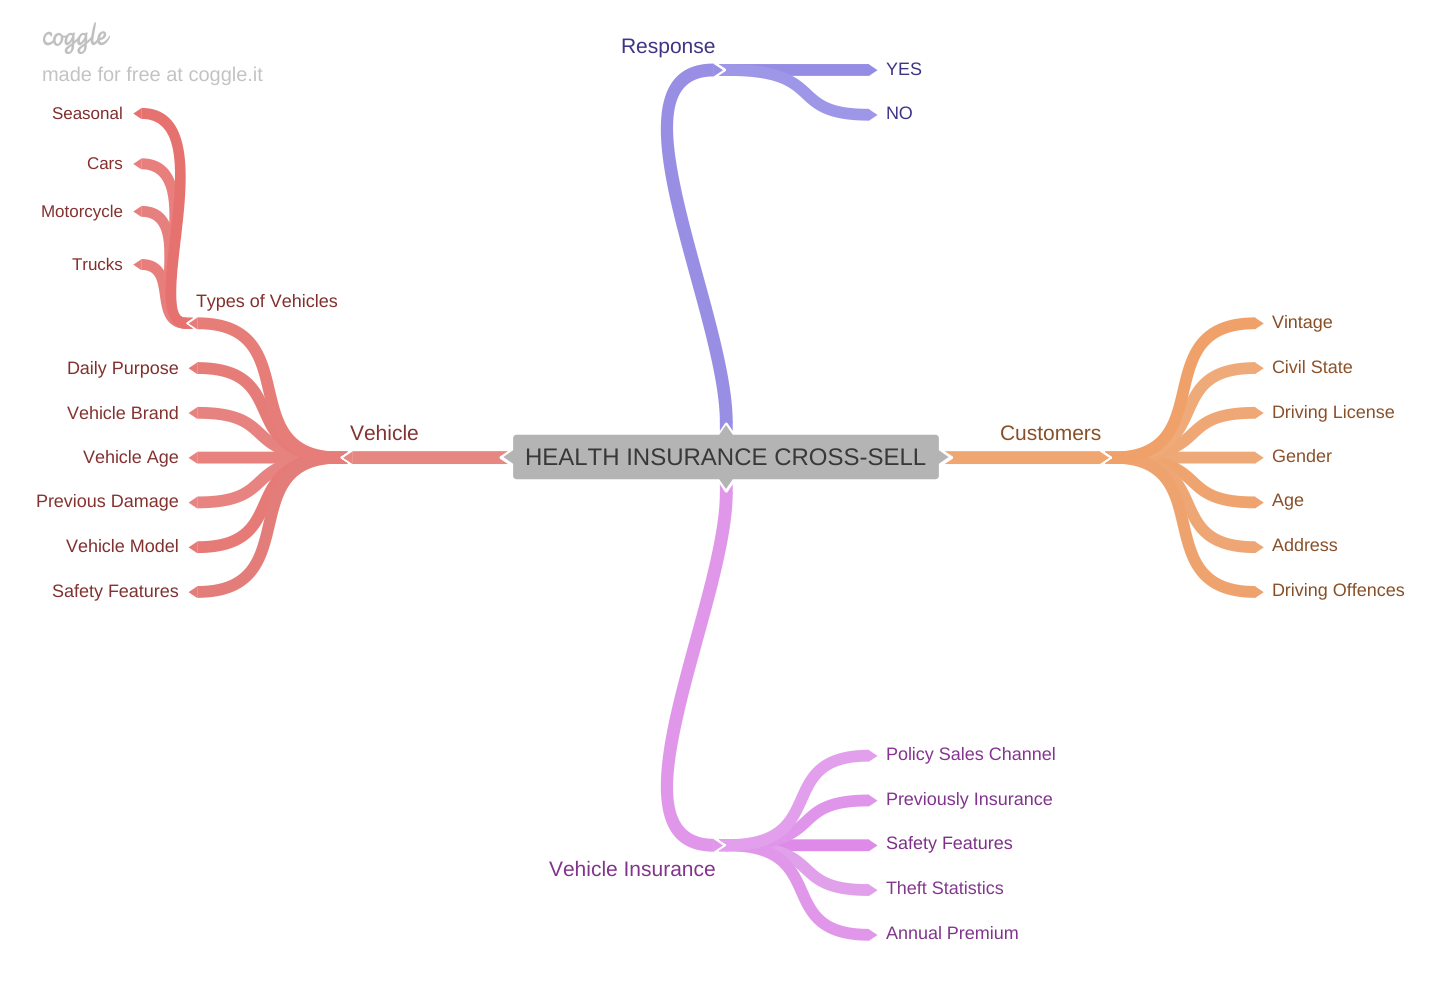

In [16]:
Image('../reports/figures/MM.png')

## 2.2. List of Hypothesis

- **H1:** Customers without driving license are not interested in buying insurance.
- **H2:** Customers who have been insured longer are interested in buying insurance.
- **H3:** Customers with damaged cars are more interested in getting insurance.
- **H4:** Men are more likely to purchase insurance than women.
- **H5:** Middle-aged customers are more interested in purchasing insurance.

## 2.3. Feature Engineering

In [17]:
 # vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                            'between_1_2_year' if x == '1-2 Year' else 
                                            'below_1_year')

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [18]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis

In [19]:
df4 = df3.copy()

## 4.1. Univariate Analysis

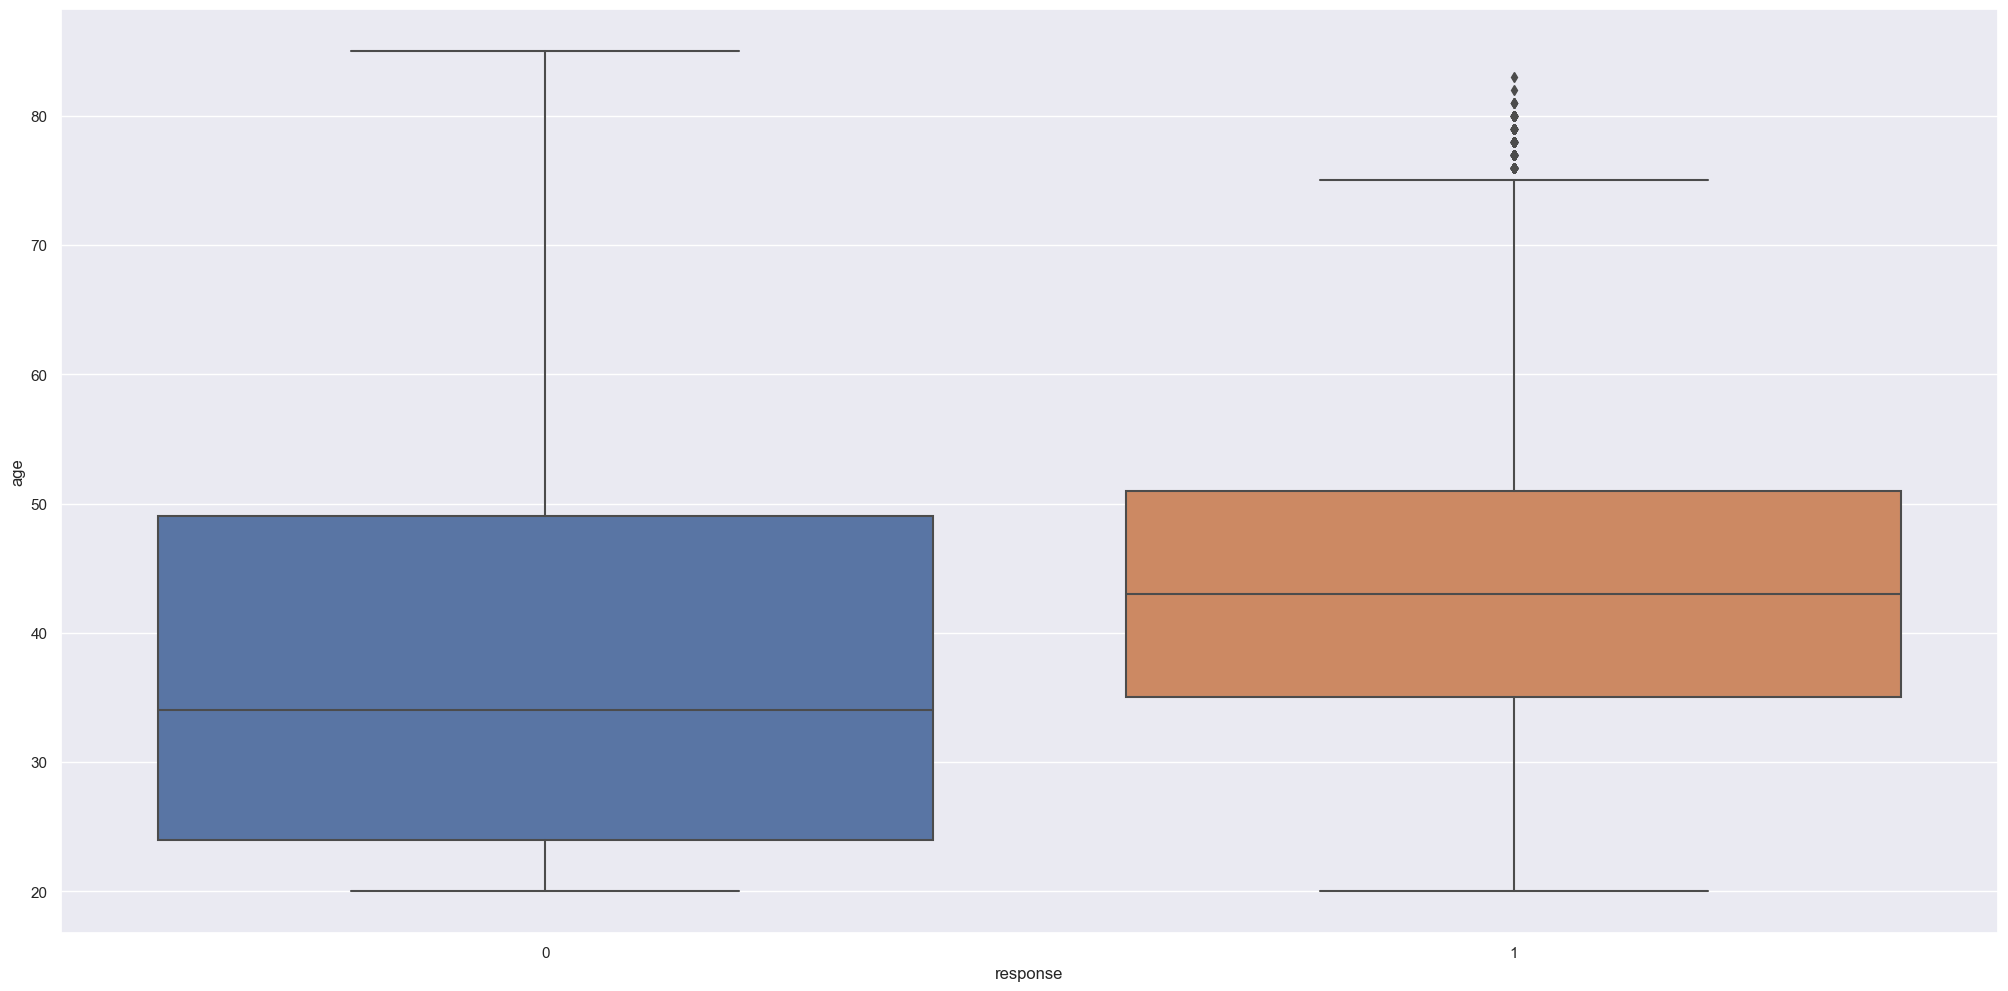

In [20]:
# age
sns.boxplot(x = 'response', y = 'age', data = df4);

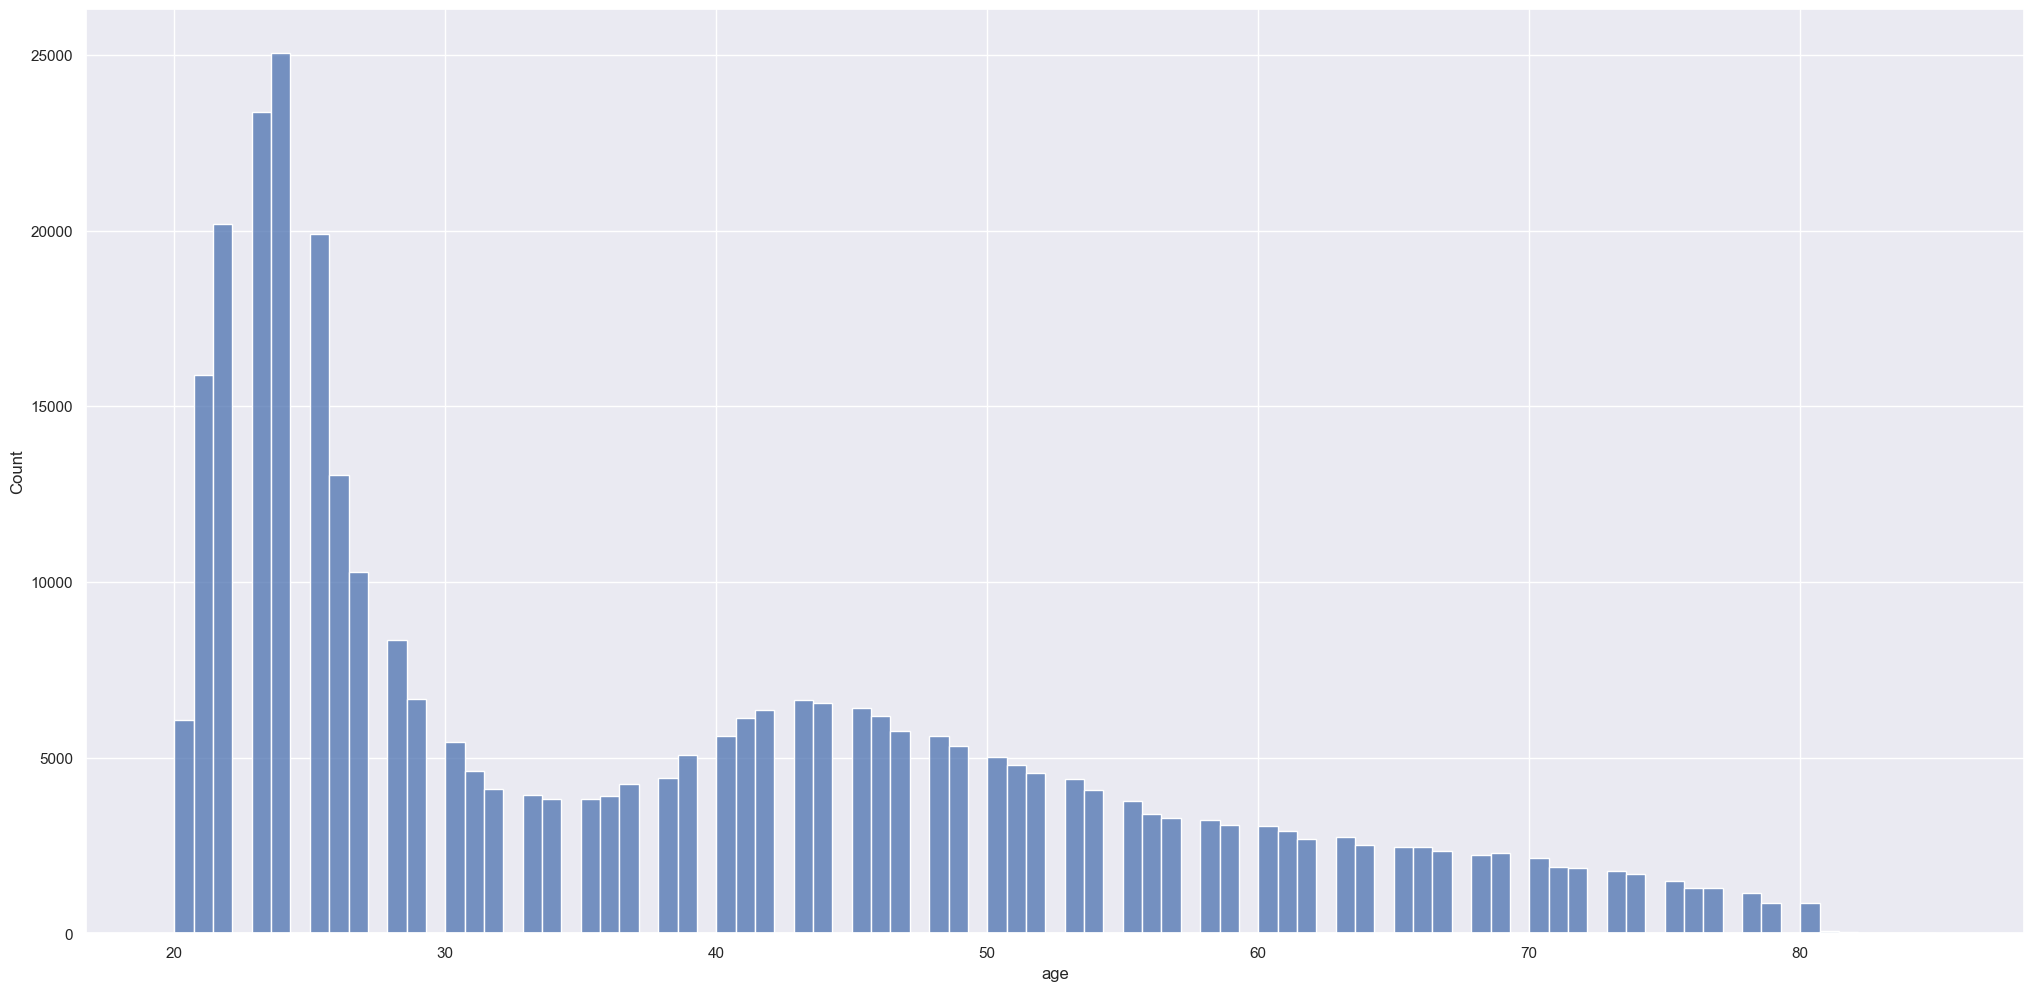

In [21]:
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux1);

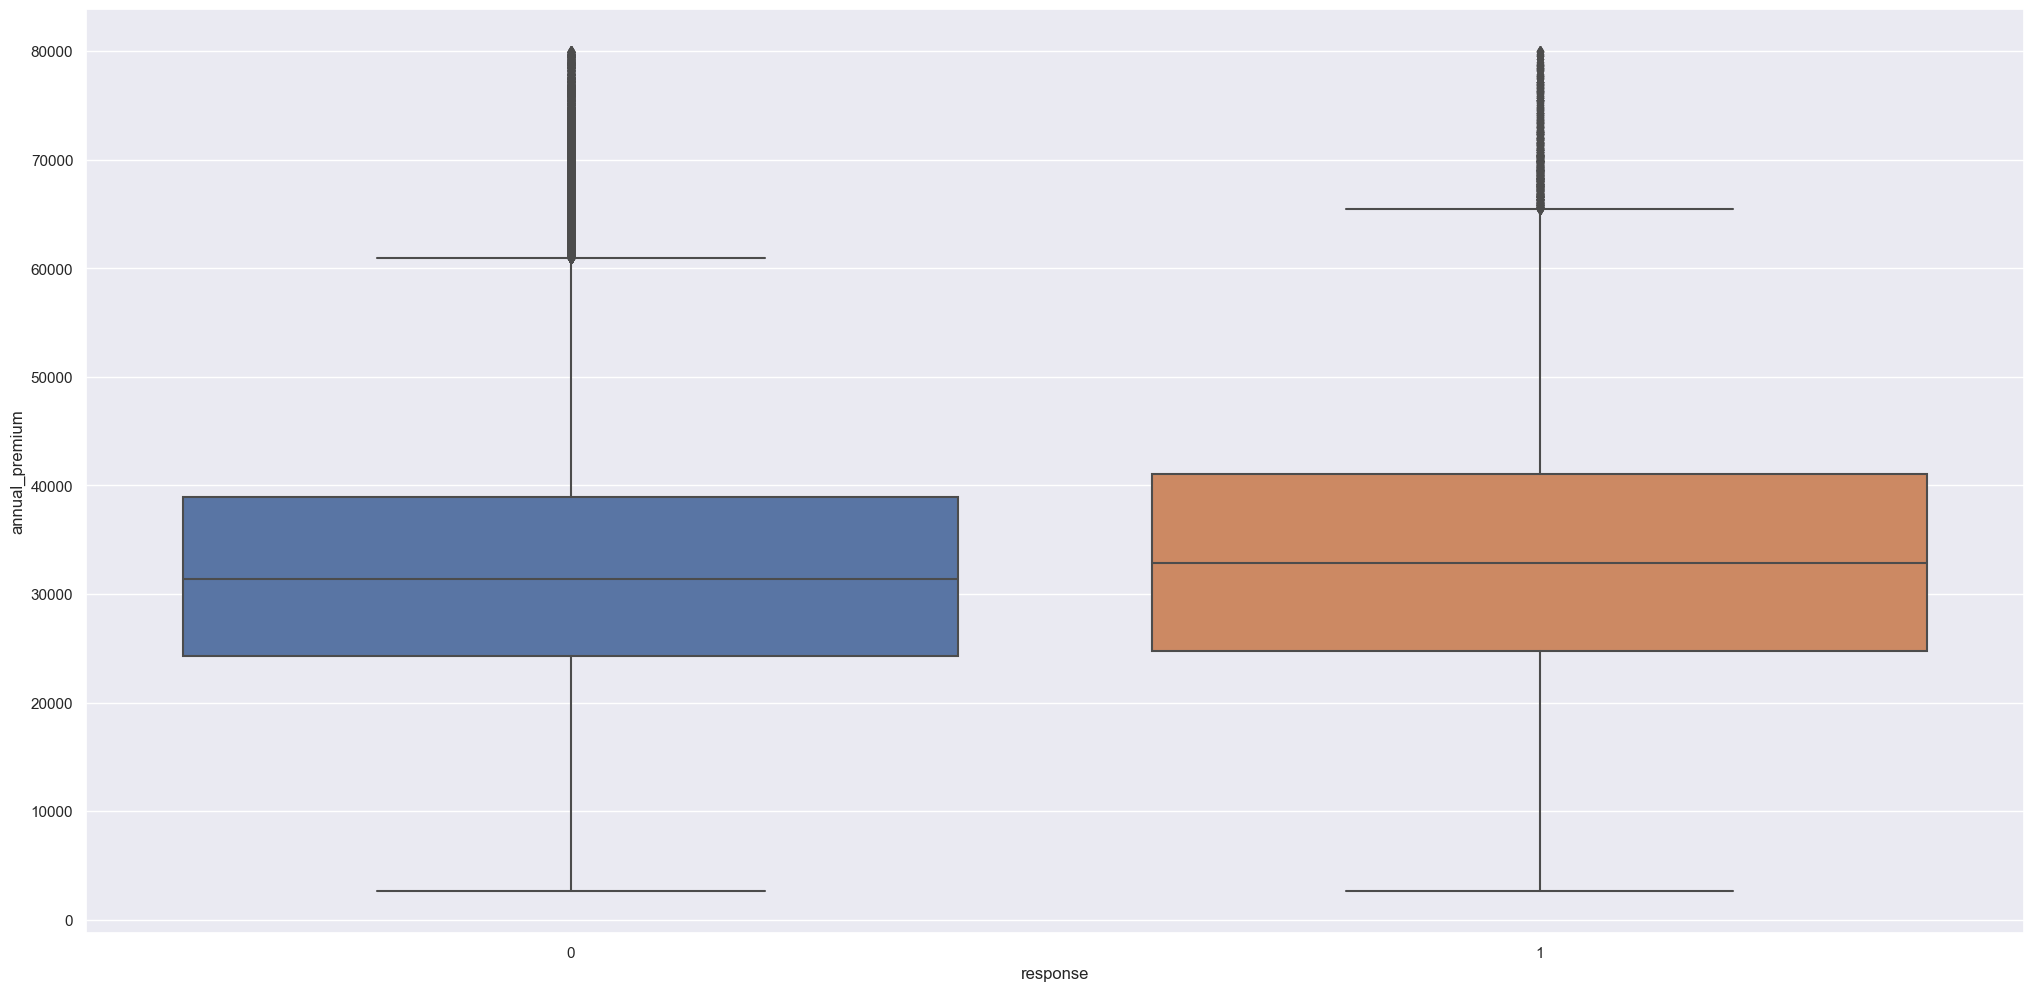

In [22]:
# annual premium

aux2 = df4[df4['annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = aux2);

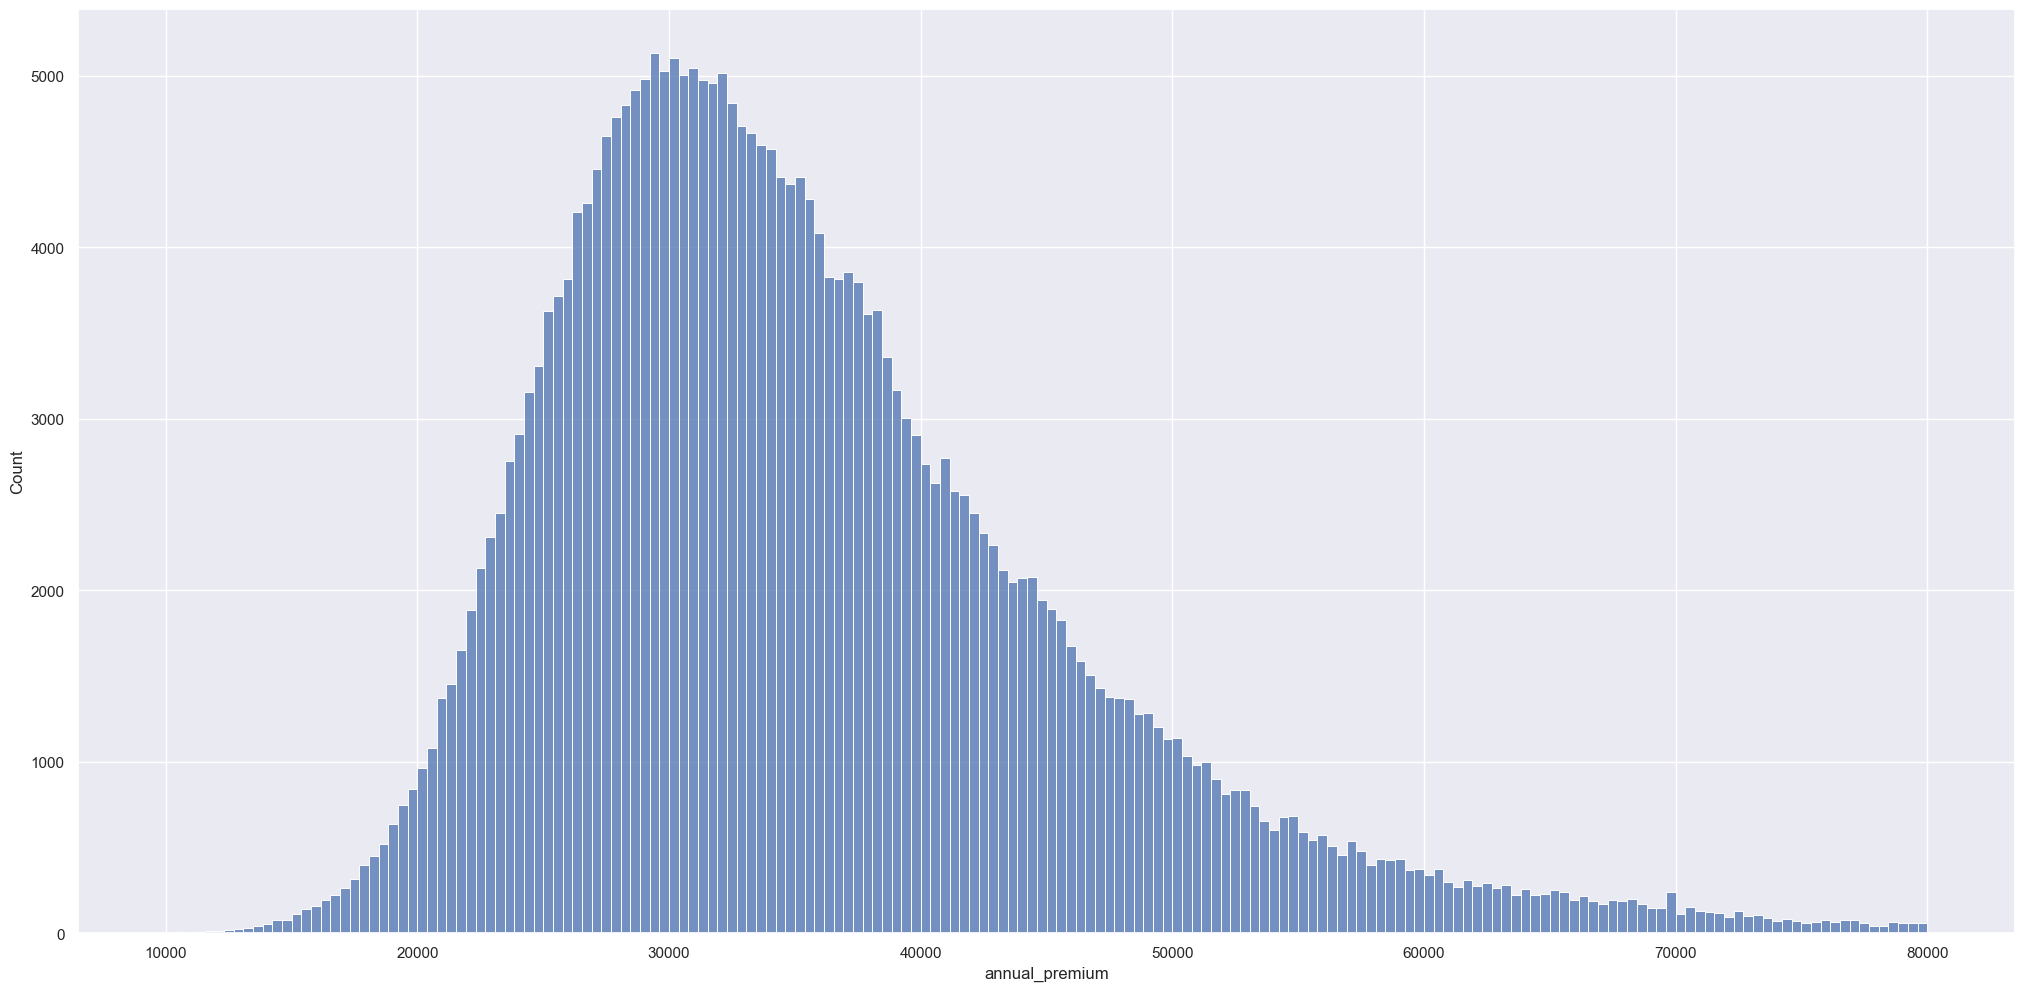

In [23]:
aux3 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux4 = aux3.loc[aux3['response'] == 0, 'annual_premium']
sns.histplot(aux4);

<Axes: xlabel='annual_premium', ylabel='Count'>

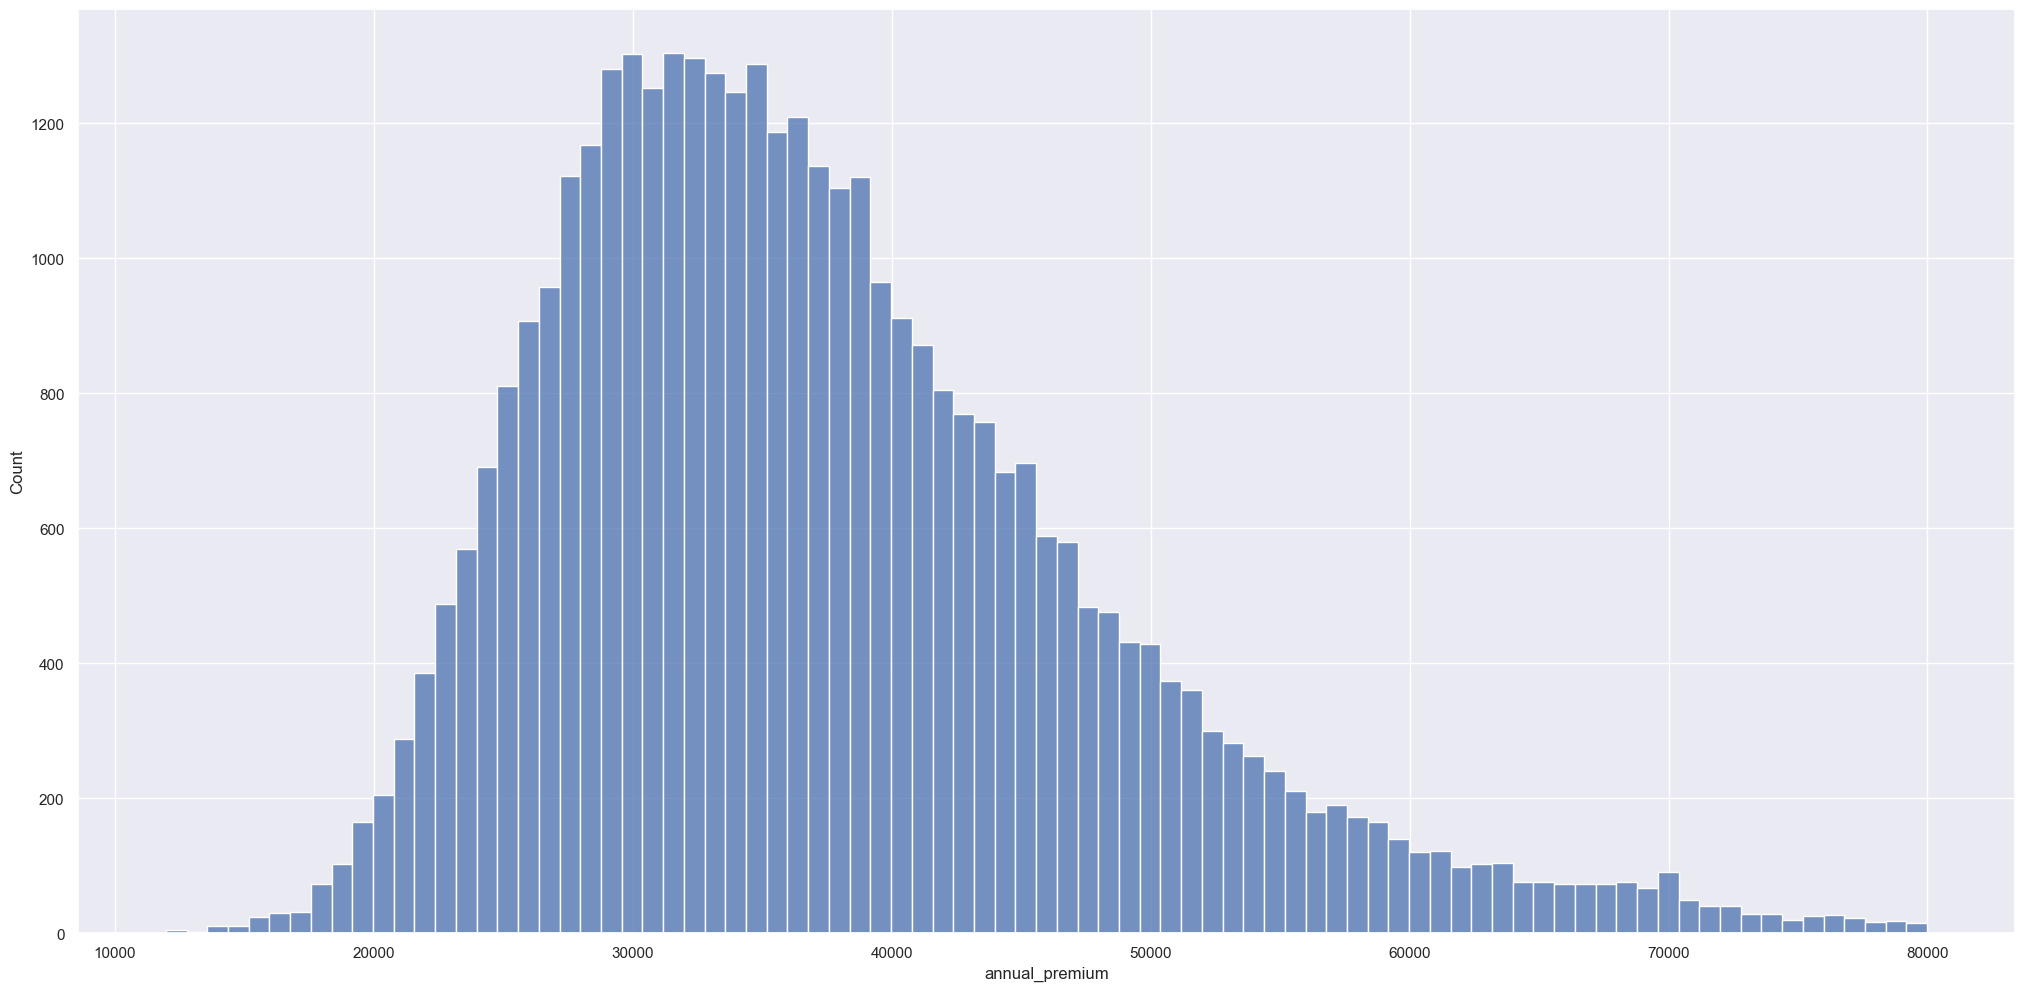

In [24]:
aux5 = aux3.loc[aux3['response'] == 1, 'annual_premium']
sns.histplot(aux5)

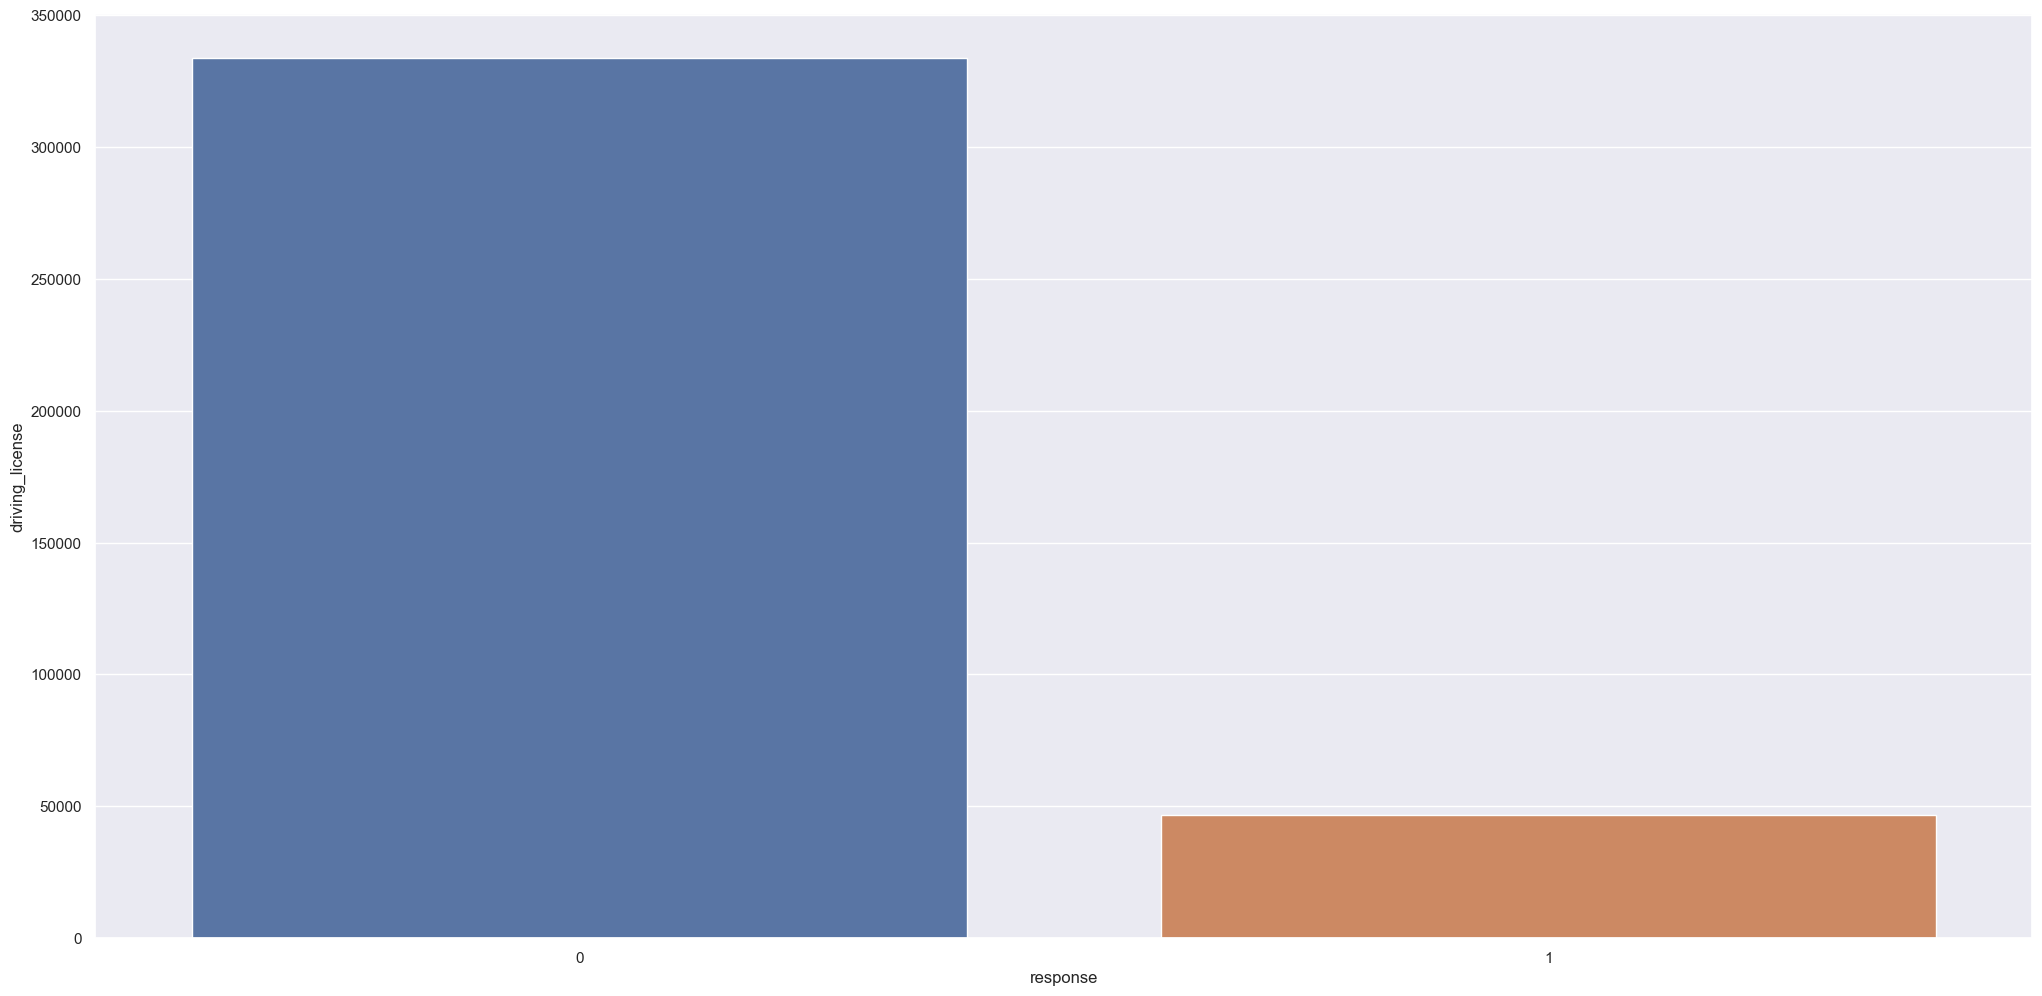

In [25]:
# driving_license

aux6 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux6['driving_license_perc'] = aux6['driving_license'] / aux6['driving_license'].sum()
sns.barplot(x='response', y='driving_license', data=aux6);

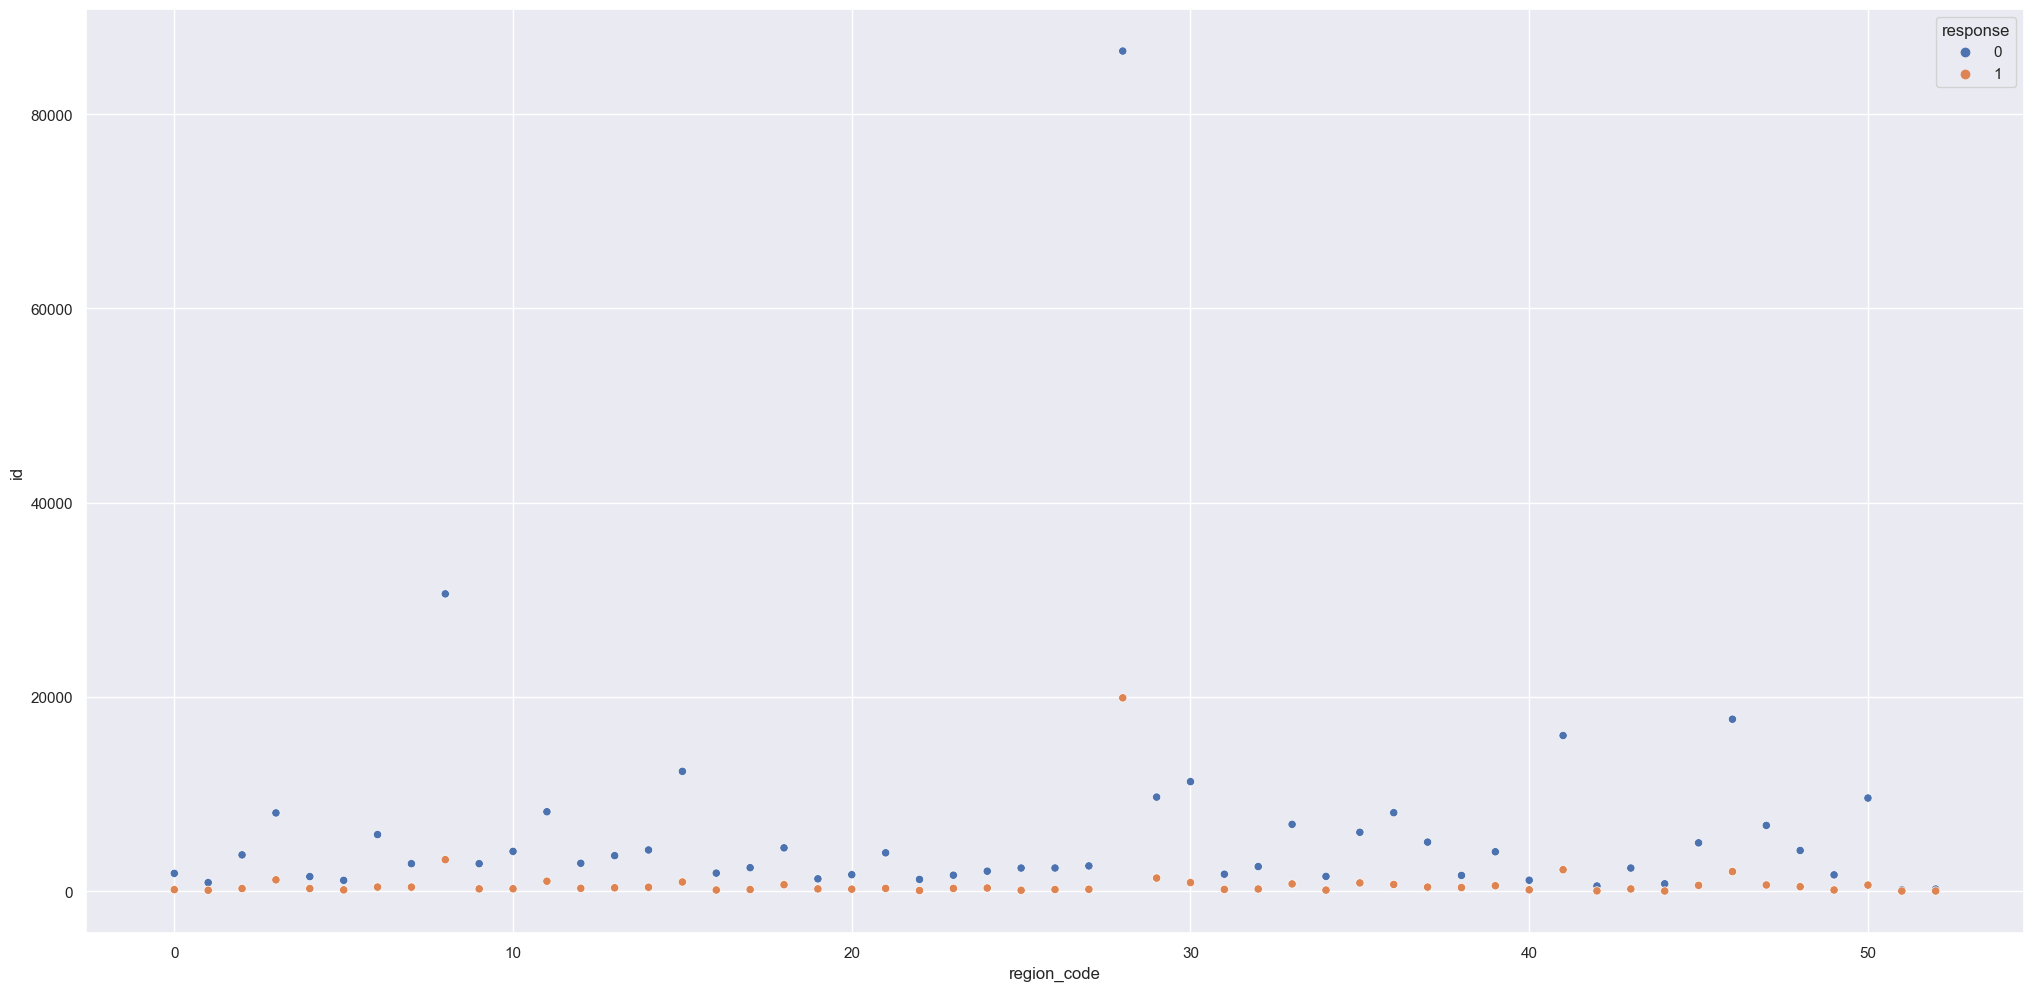

In [26]:
# region_code -> this didn't worked, why?
aux7 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data=aux7);

In [27]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [28]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


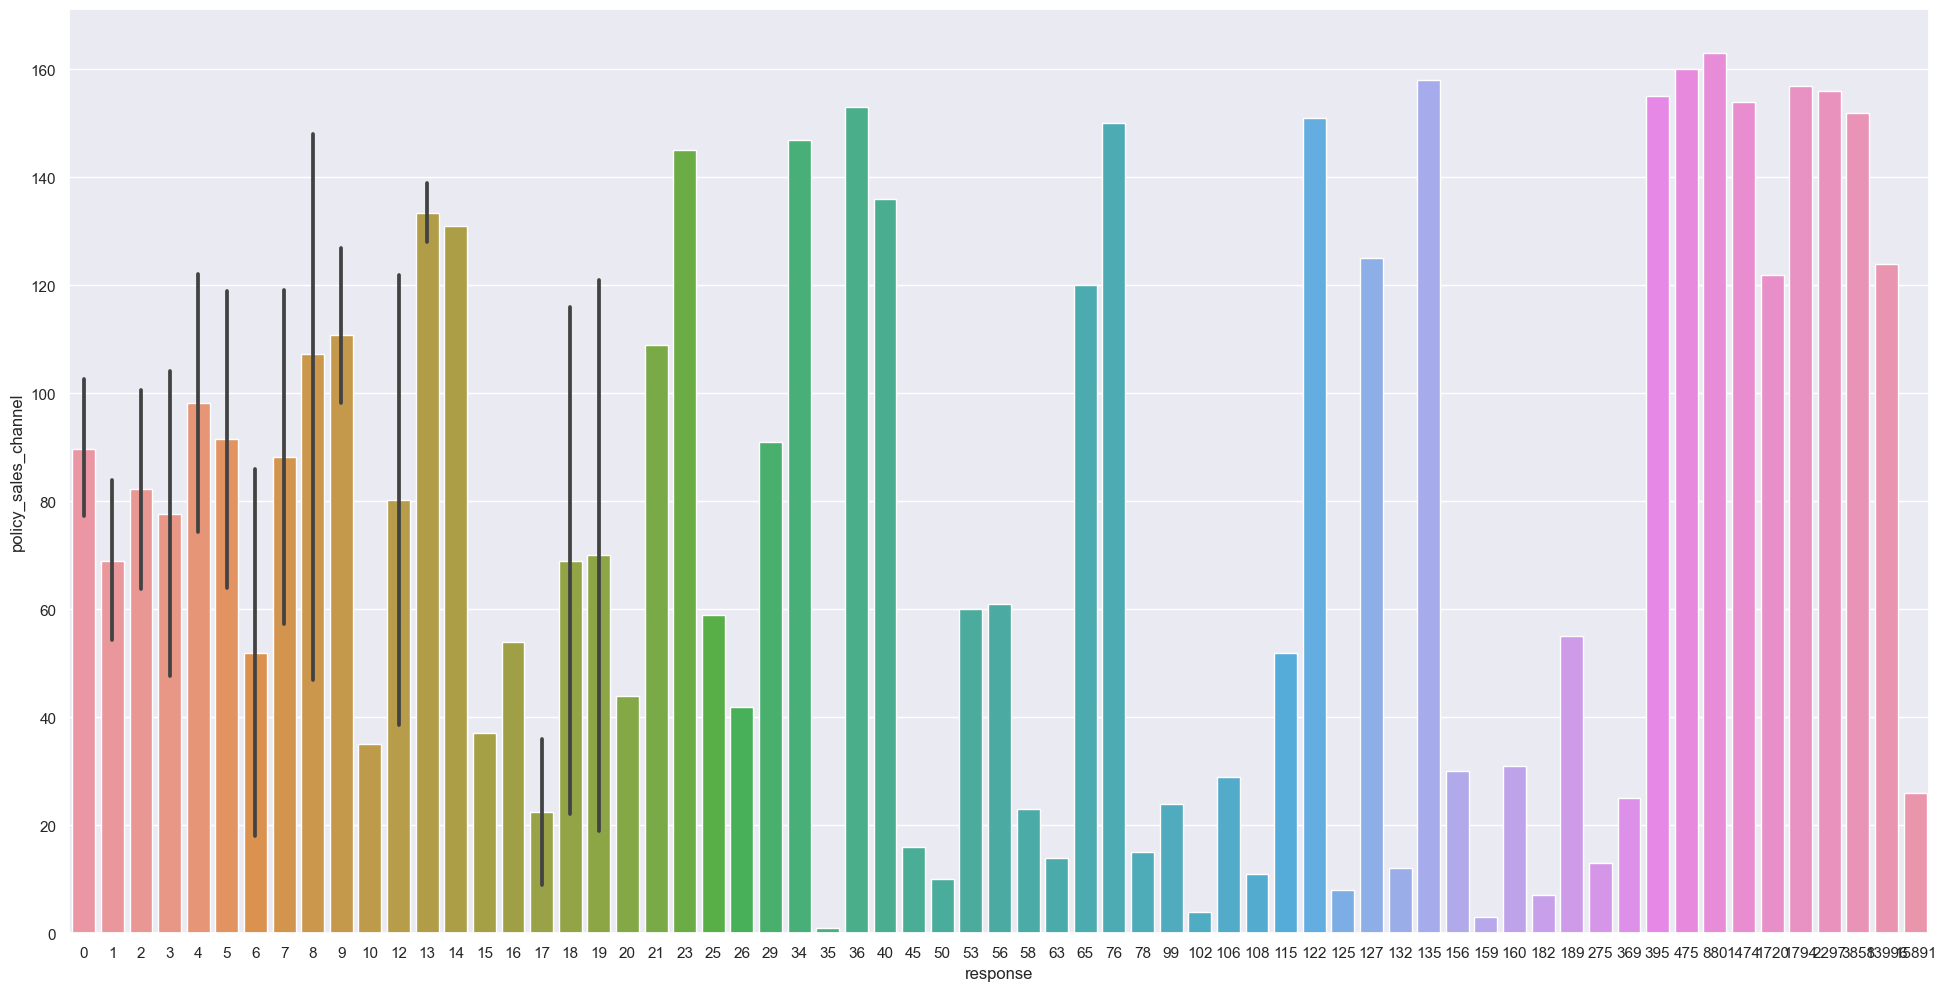

In [29]:
# policy_sales_channel
plt.figure(figsize = (24, 12))
aux8 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x = 'response', y = 'policy_sales_channel', data = aux8);

In [30]:
# vintage

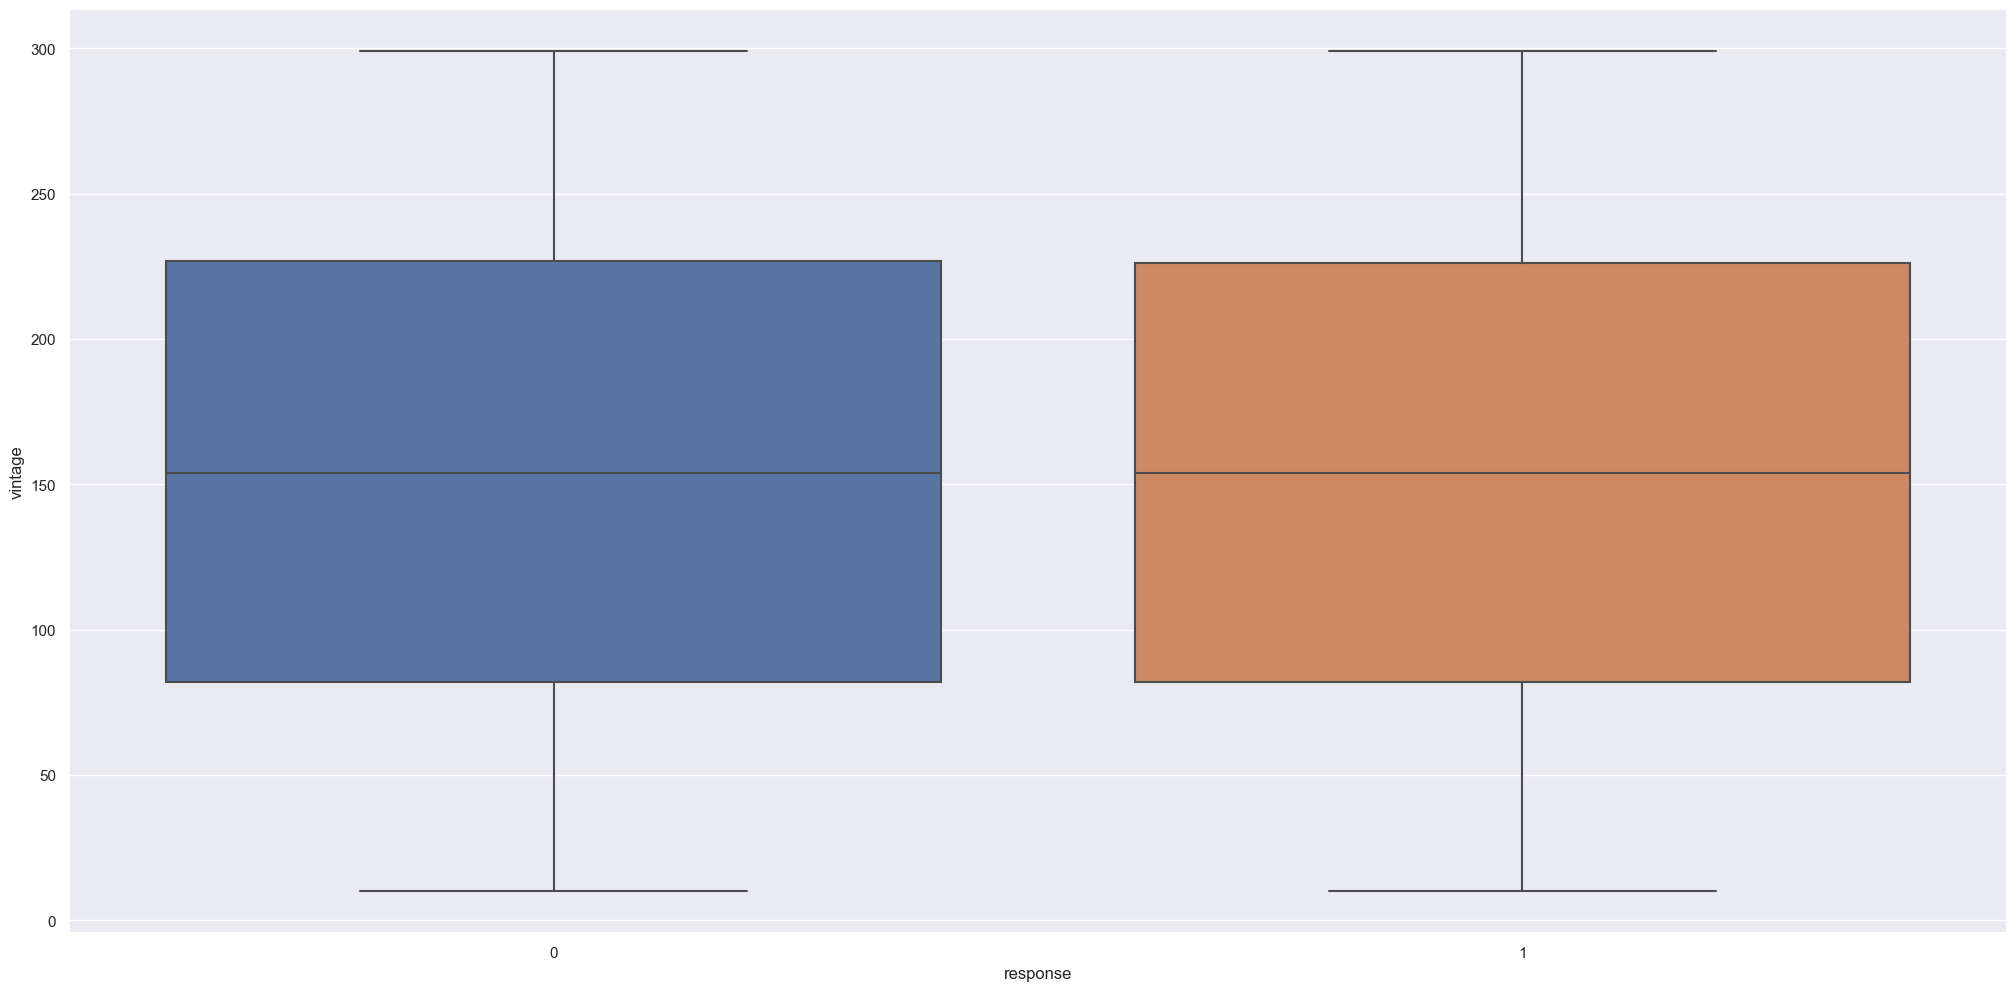

In [31]:
# annual_premium
sns.boxplot(x = 'response', y = 'vintage', data = df4);

<Axes: xlabel='vintage', ylabel='Count'>

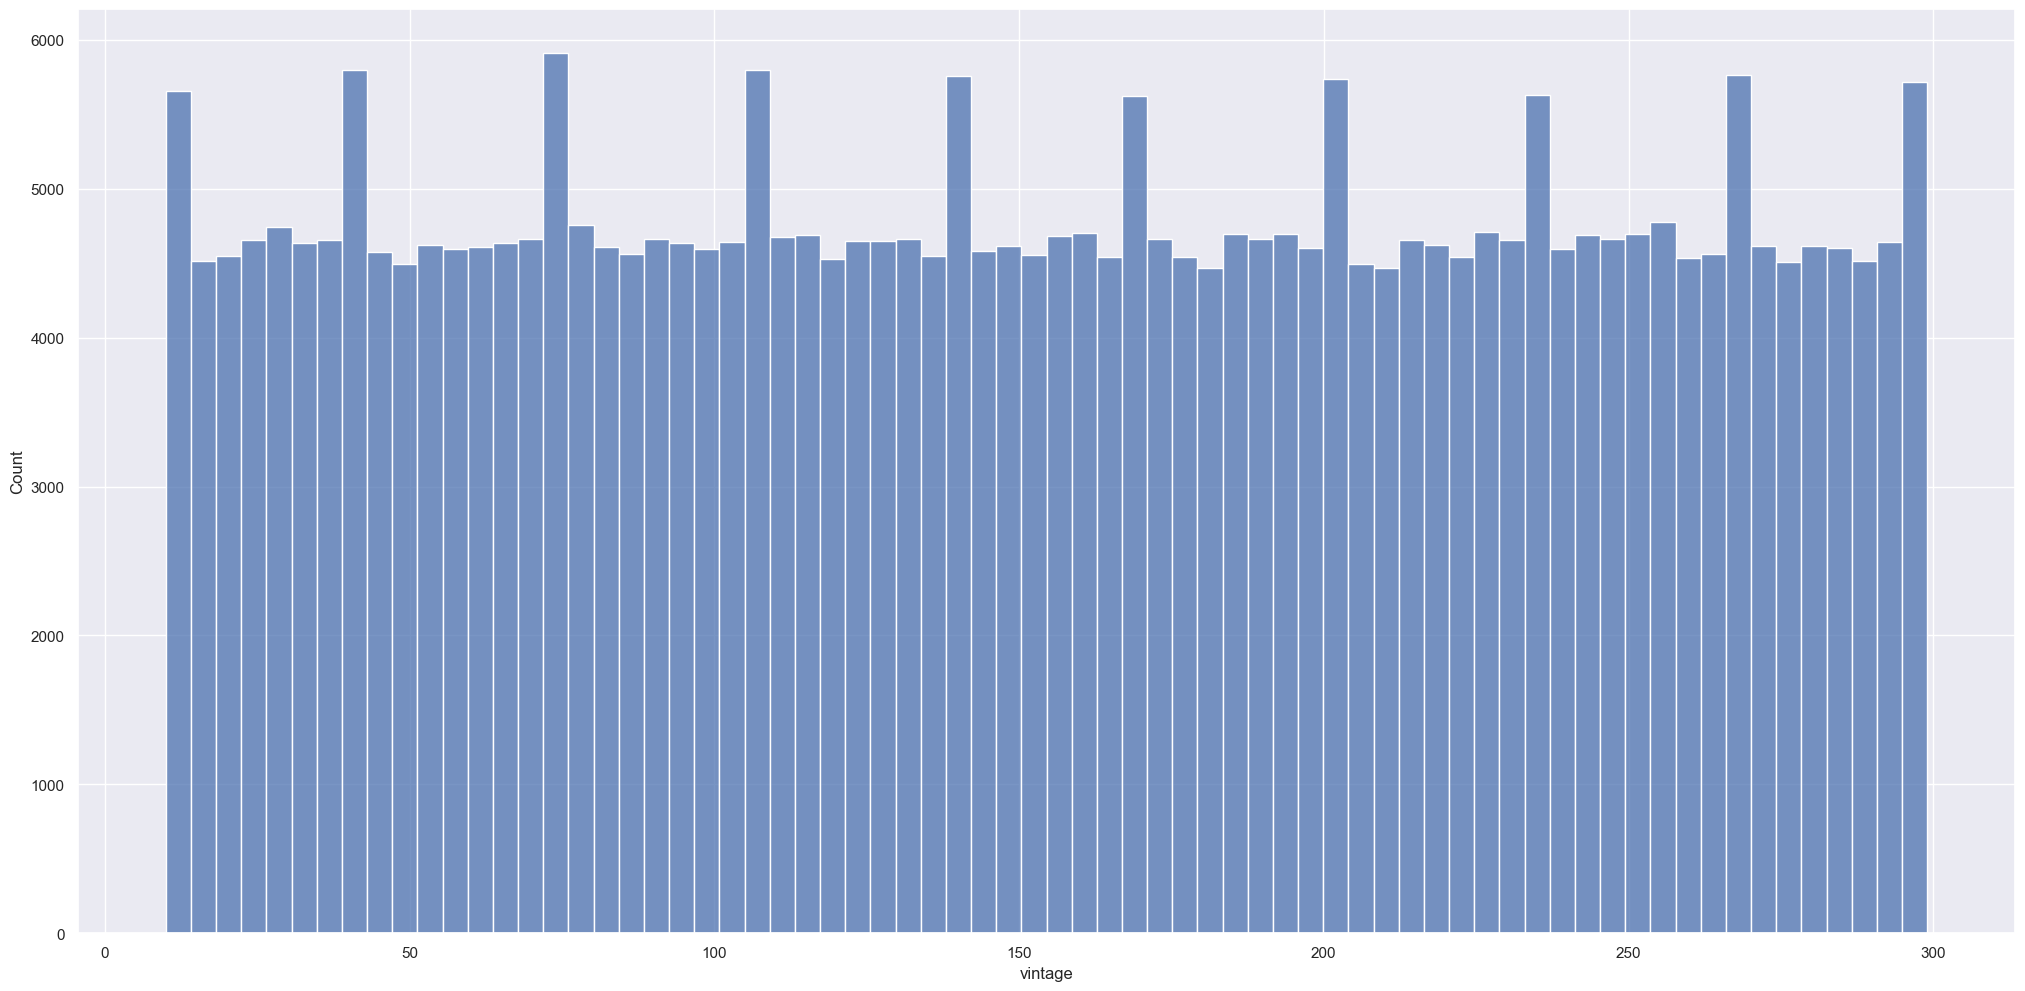

In [32]:
aux9 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux9)

<Axes: xlabel='vintage', ylabel='Count'>

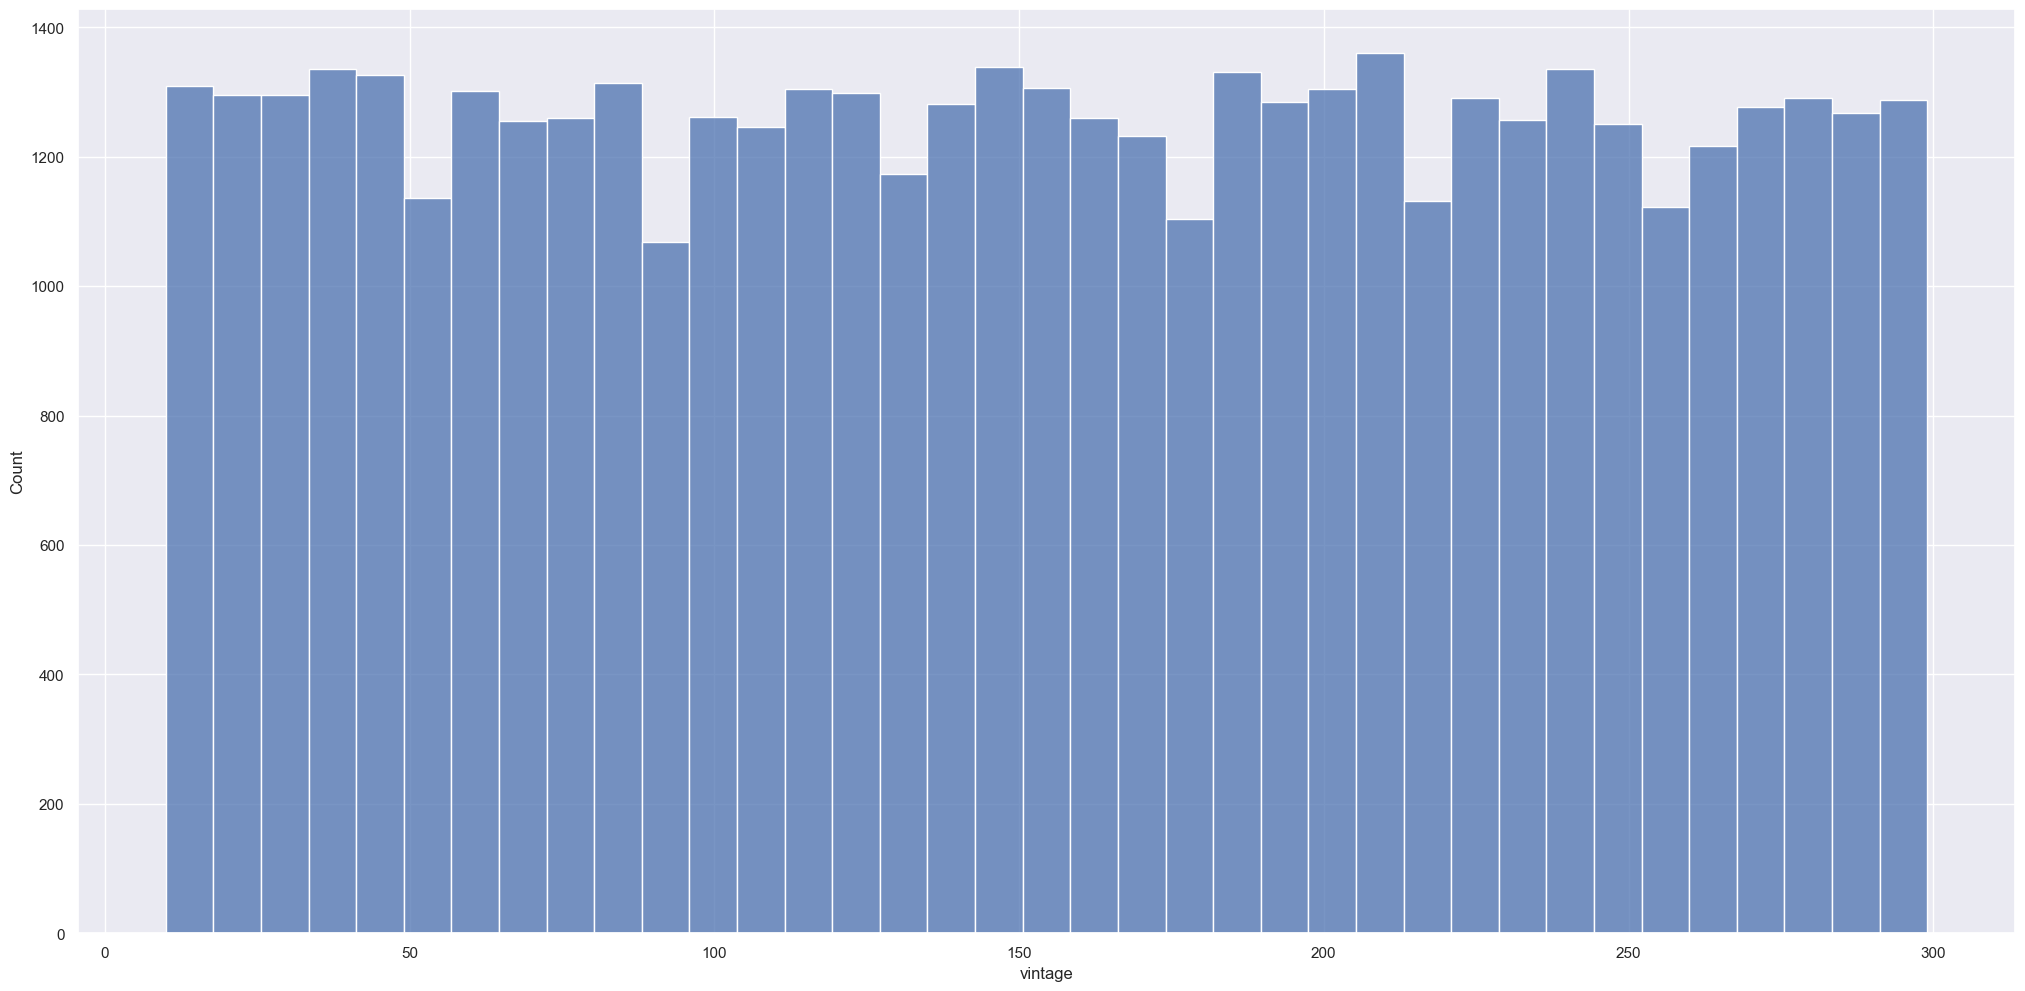

In [33]:
aux10 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux10)

## 4.2. Bivariate Analysis

- **H1**: younger customers are more likely to be interested in purchasing vehicle insurance than older customers.
- **H2**:  customers who have previously purchased SafeHarbor health insurance are more likely to be interested in purchasing vehicle insurance than those who have not.
- **H3:** customers who have been insured longer are interested in buying insurance.
- **H4:** customers with damaged cars are more interested in getting insurance.
- **H5:** Men are more likely to purchase insurance than women.
- **H6**: customers who own older vehicles are more likely to be interested in purchasing vehicle insurance than those who own newer vehicles.

### **H1**: younger customers are more likely to be interested in purchasing vehicle insurance than older customers.

**False**: most of the clients interested in purchasing insurance are around 35 to 50 years old.

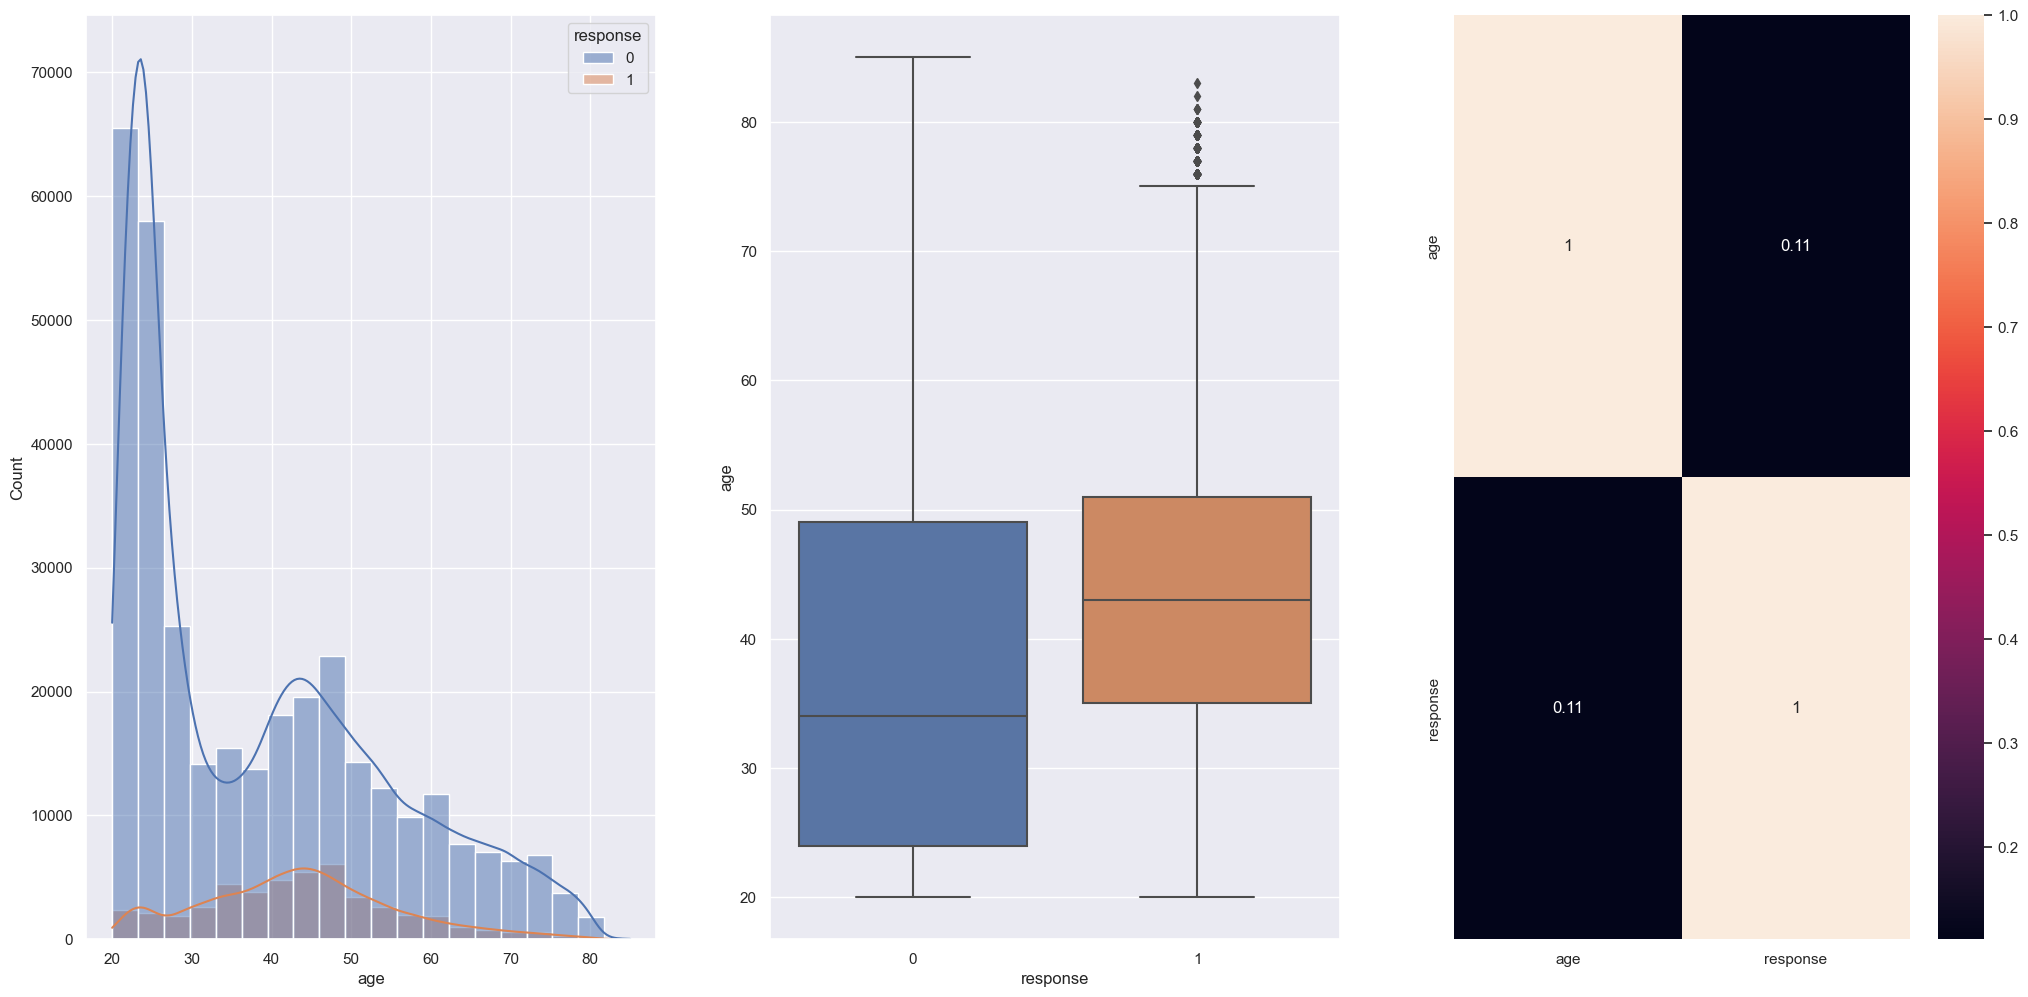

In [34]:
plt.subplot(1, 3, 1)
sns.histplot(x = 'age', hue = 'response', kde = True, bins = 20, data = df4)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'response', y = 'age', data = df4)

plt.subplot(1, 3, 3)
sns.heatmap(df4[['age', 'response']].corr(method = 'pearson'), annot = True);

### **H2**:  customers who have previously purchased SafeHarbor health insurance are more likely to be interested in purchasing vehicle insurance than those who have not.

**False**: customers which doesn't purchased SafeHarbor health insurance previously are the more inclined to buy vehicle insurance.

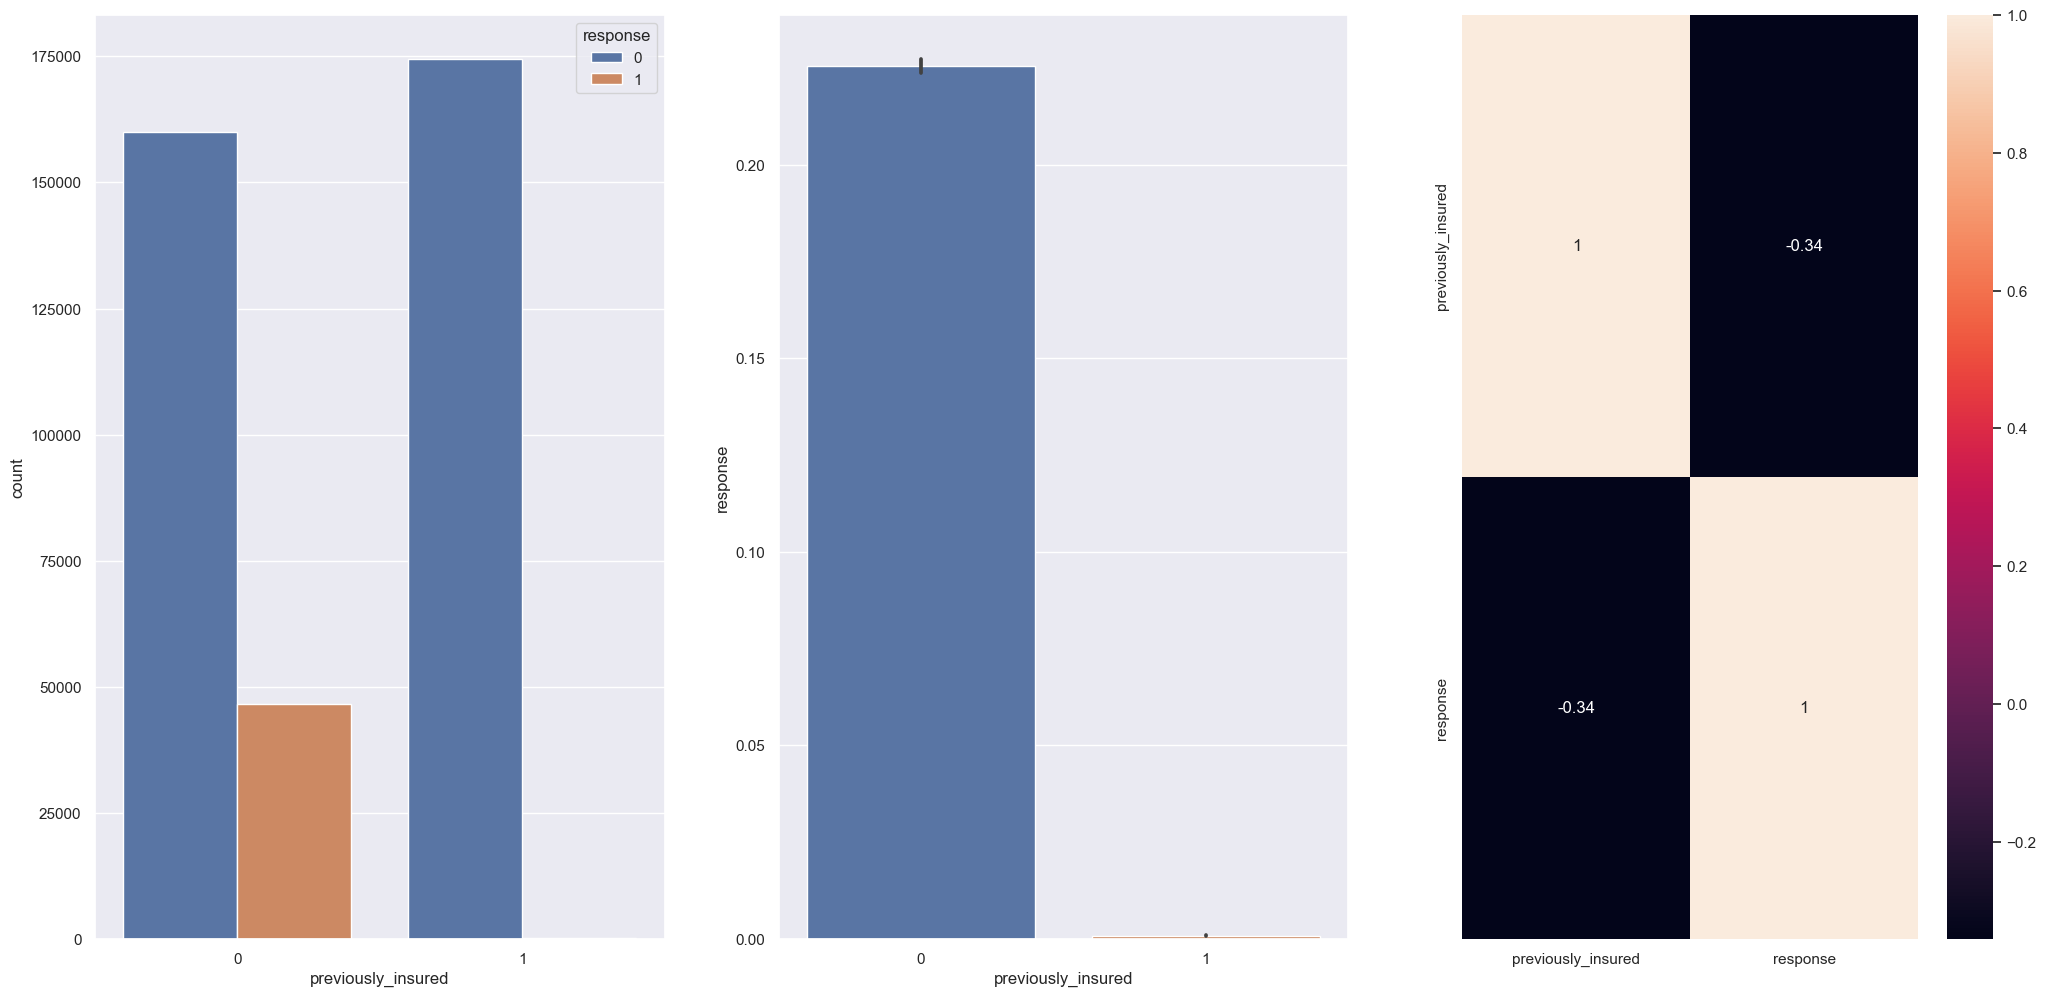

In [35]:
plt.subplot(1, 3, 1)
sns.countplot(x = 'previously_insured', hue = 'response', data = df4)

plt.subplot(1,3,2)
sns.barplot(x = 'previously_insured', y = 'response', data = df4)

plt.subplot(1, 3, 3)
sns.heatmap(df4[['previously_insured', 'response']].corr(method = 'pearson'), annot = True);

### **H3:** customers who have been insured longer are interested in buying insurance.

**False**: The fact that these clients have had health insurance for a long time does not show a tendency for them to also purchase vehicle insurance from the same company. 

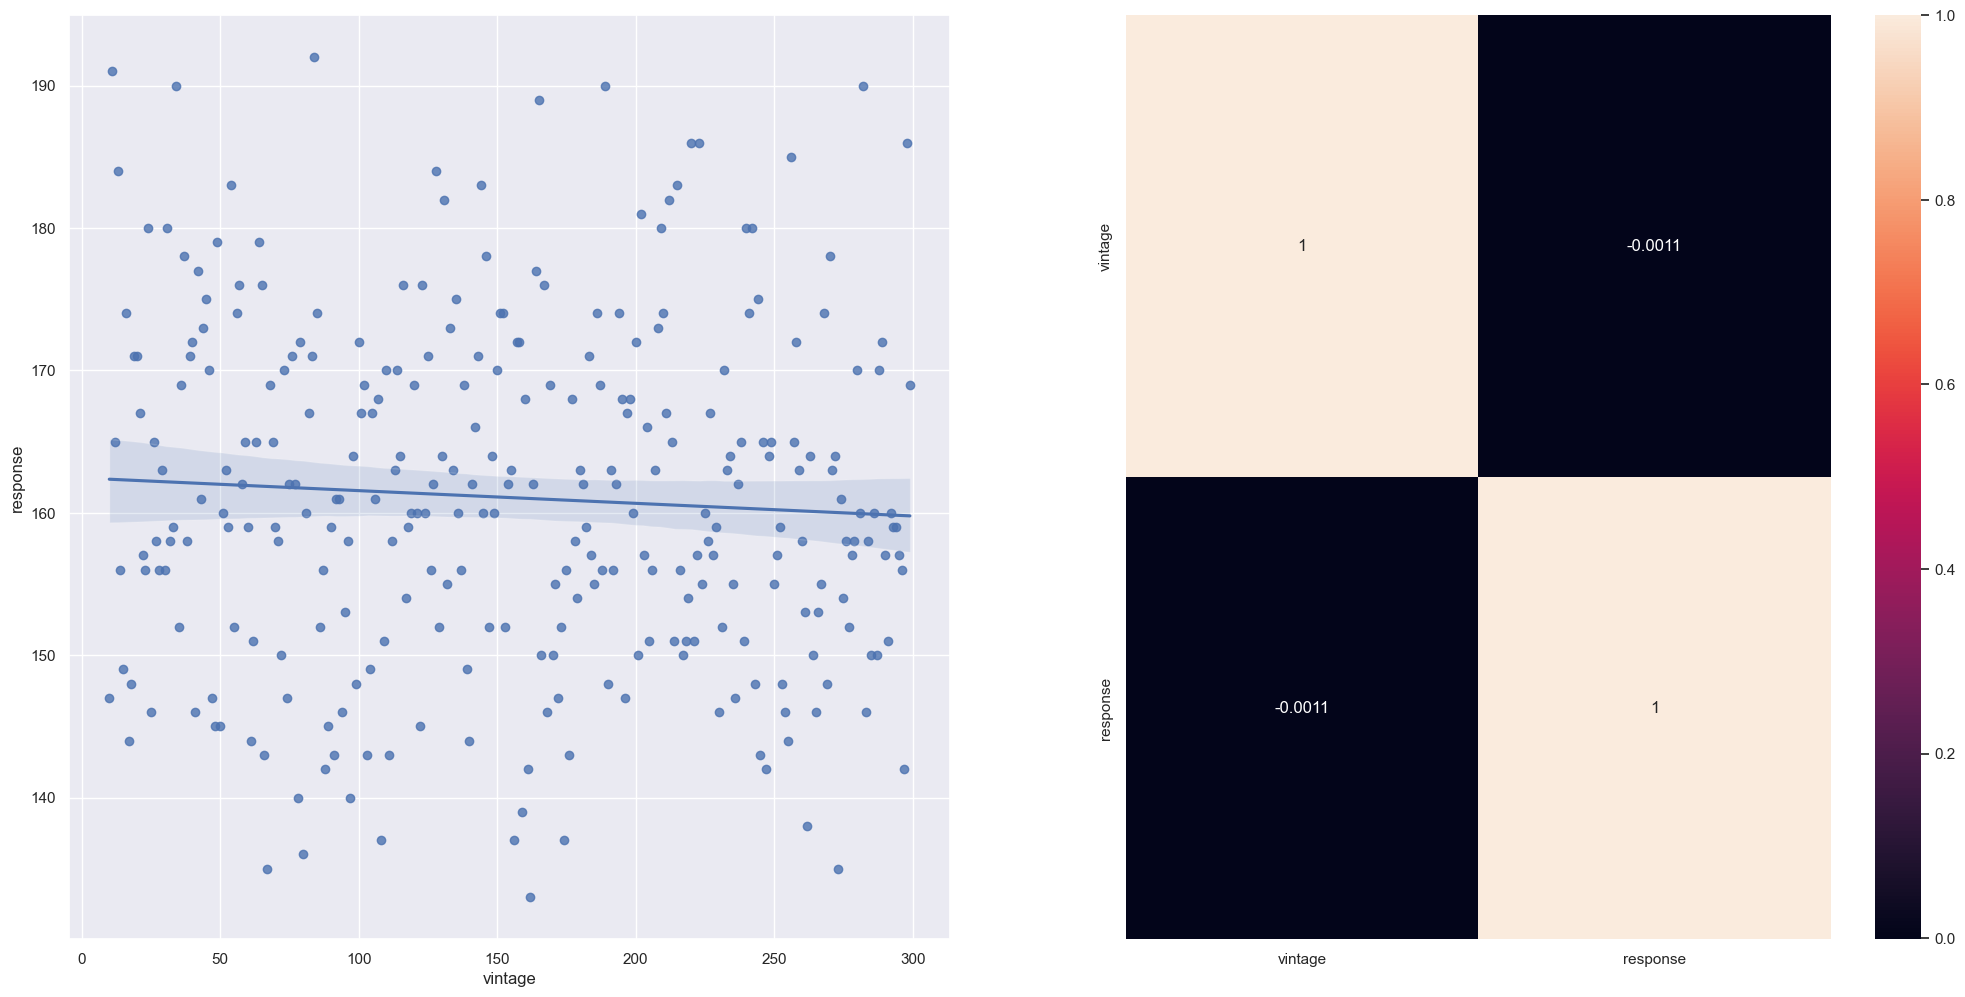

In [36]:
plt.subplot(1, 2, 1)
aux = df4[['vintage', 'response']].groupby('vintage').sum().reset_index()
sns.regplot(x = 'vintage', y = 'response', data = aux)

plt.subplot(1, 2, 2)
sns.heatmap(df4[['vintage', 'response']].corr(method = 'pearson'), annot = True);

### **H4:** customers with damaged cars are more interested in getting insurance.

**True**: indeed, customers with damaged cars are more interested in getting insurance.

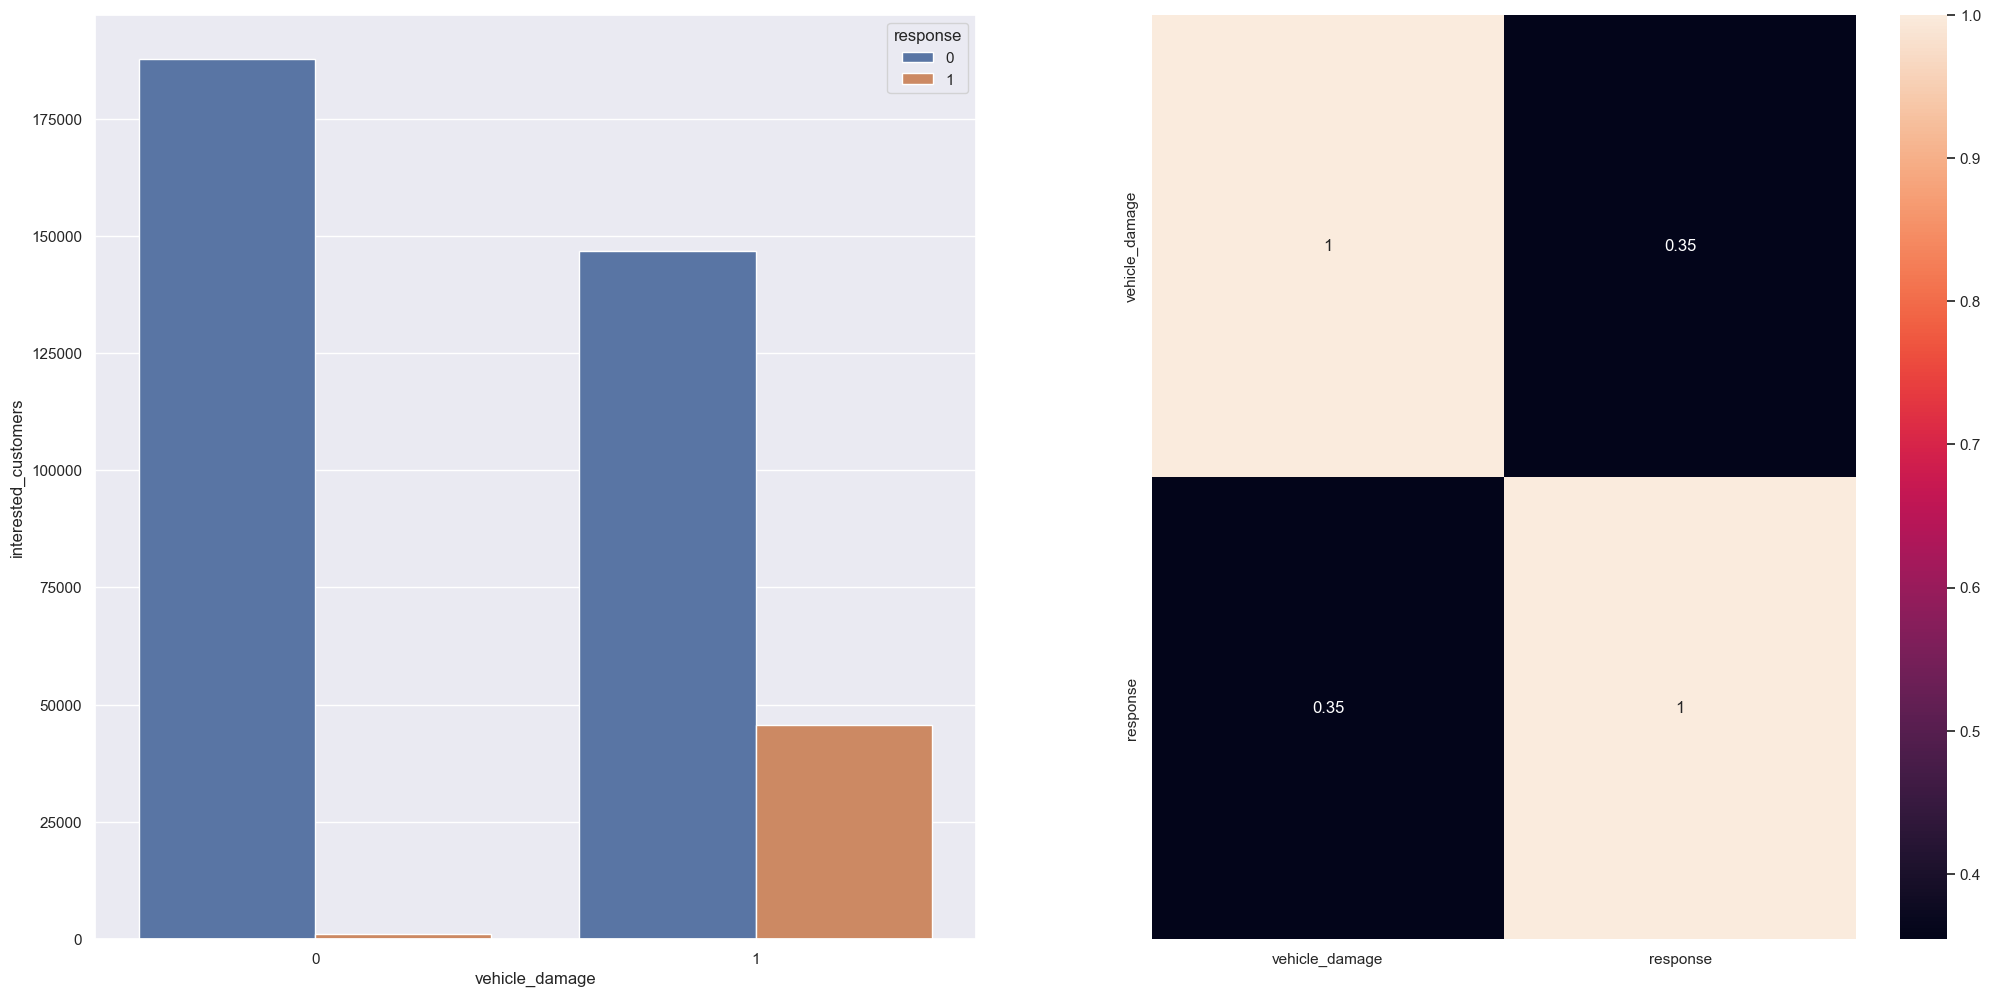

In [37]:
plt.subplot(1, 2, 1)
aux = df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'interested_customers'})
sns.barplot(x = 'vehicle_damage', y = 'interested_customers', hue = 'response', data = aux)

plt.subplot(1, 2, 2)
sns.heatmap(df4[['vehicle_damage', 'response']].corr(method = 'pearson'), annot = True);

### **H5:** Men are more likely to purchase insurance than women.
**True**: Men are more willing to purchase vehicle insurance with a difference of 22.14% compared to women.

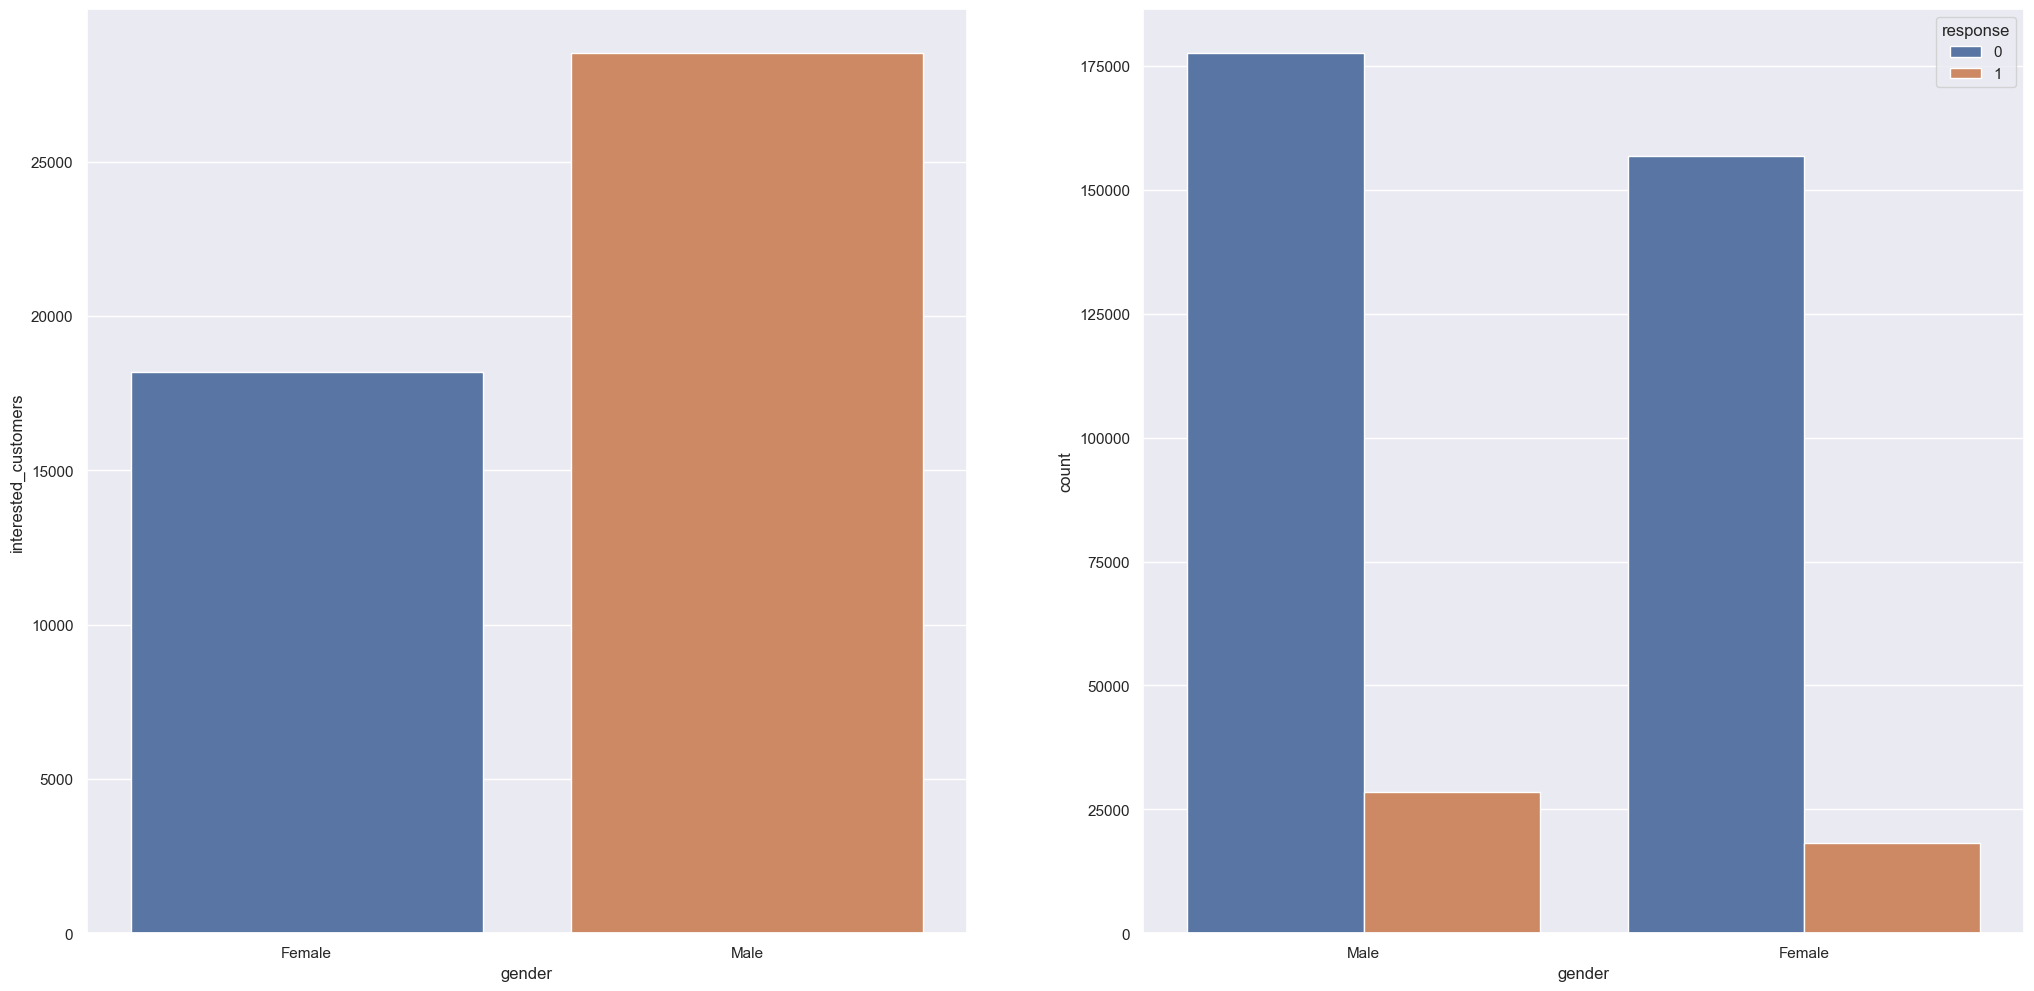

In [38]:
plt.subplot(1, 2, 1)
aux = df4[df4['response'] == 1]
aux = aux[['gender']].groupby('gender').size().reset_index().rename(columns = {0: 'interested_customers'})
sns.barplot(x = 'gender', y = 'interested_customers', data = aux)

plt.subplot(1, 2, 2)
sns.countplot(x = 'gender', hue = 'response', data = df4);

### **H6**: customers who own older vehicles are more likely to be interested in purchasing vehicle insurance than those who own newer vehicles.
**False**: customers which vehicles are between 1 and 2 years old are the ones more likely to acquire vehicle insurance

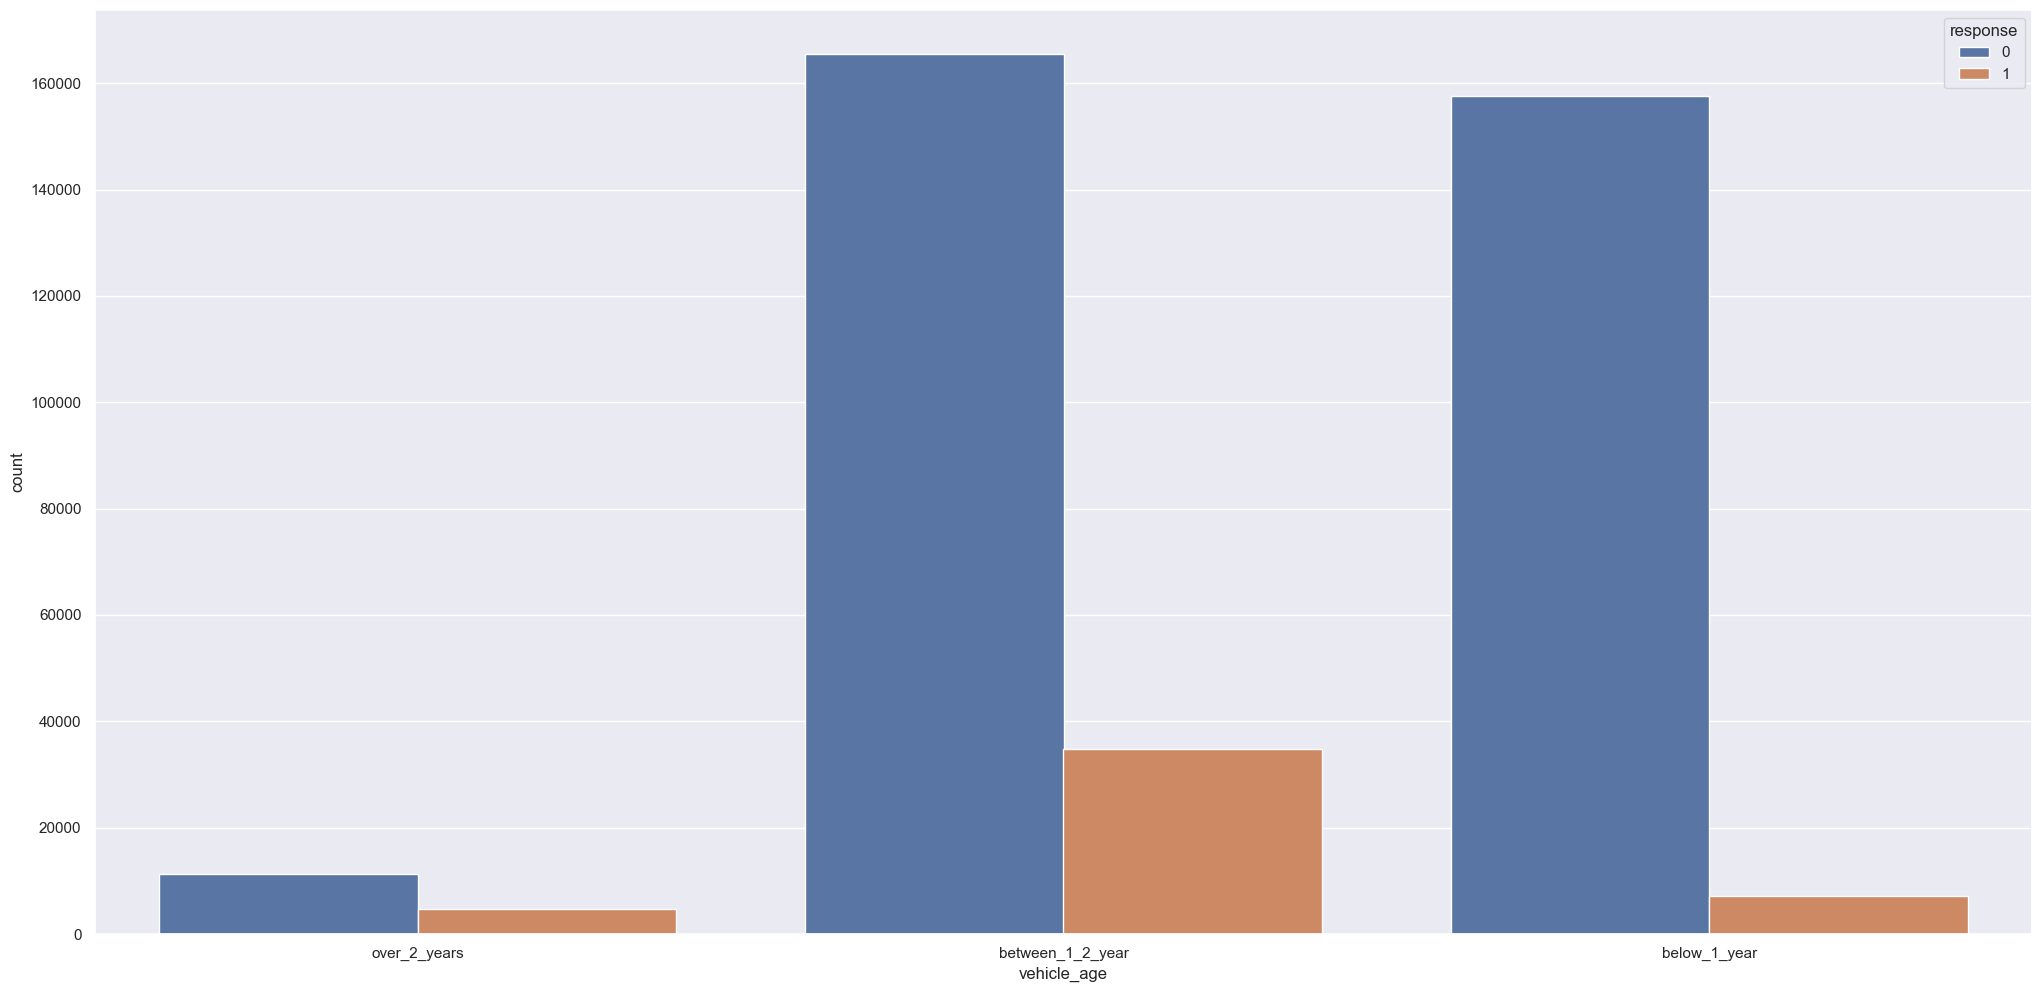

In [39]:
sns.countplot(x='vehicle_age', hue='response', data=df4);

## 4.3. Multivariate Analysis

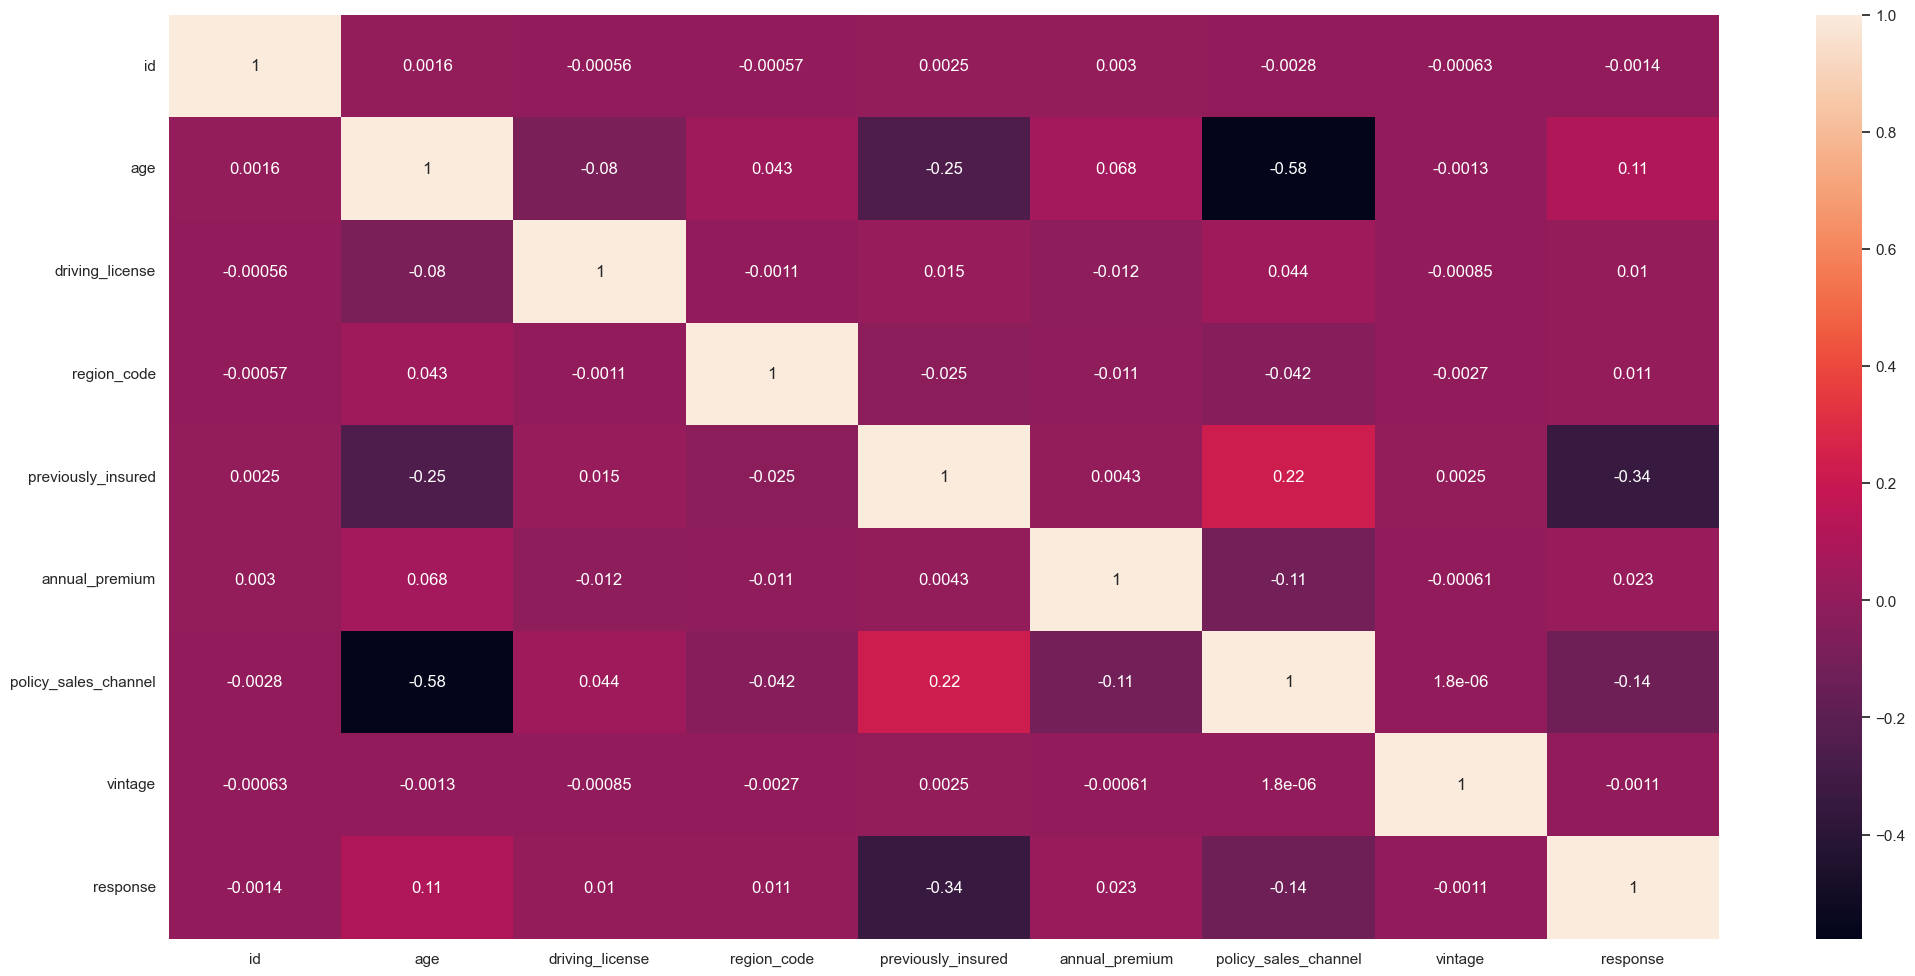

In [40]:
# Numerical Attributes

correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

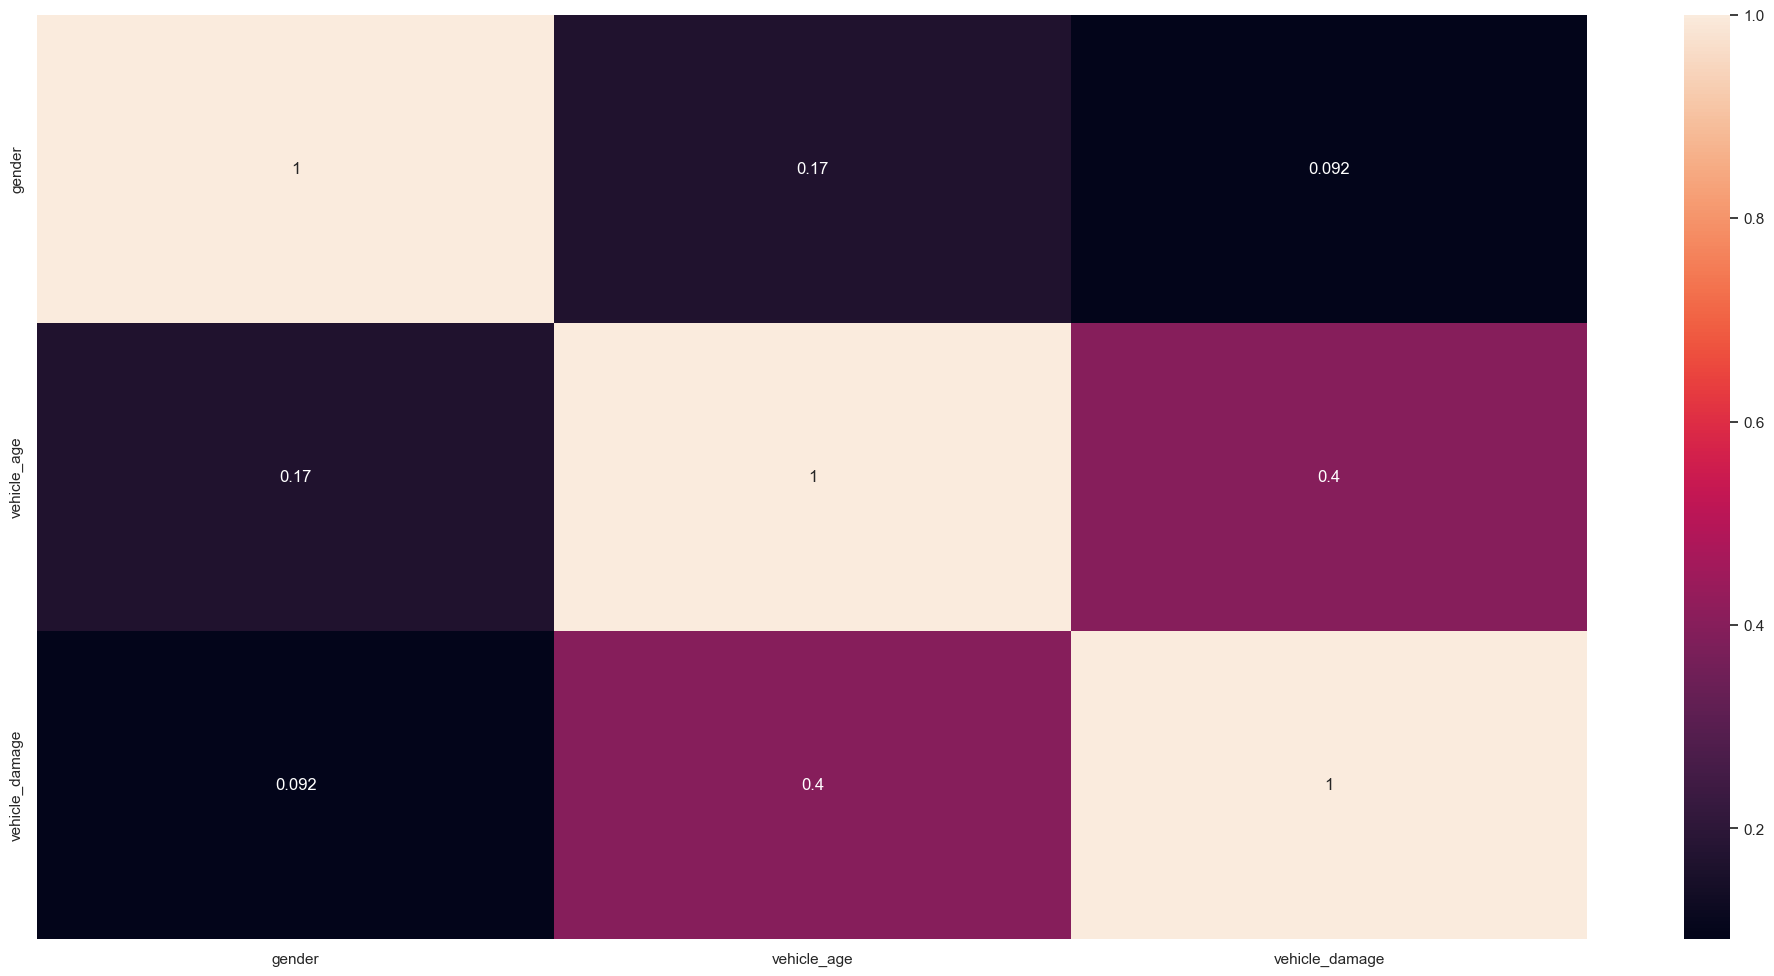

In [41]:
# Categorical Attributes

a = cat_attributes

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

b = pd.DataFrame({
    'gender': [a1, a2, a3],
    'vehicle_age': [a4, a5, a6],
    'vehicle_damage': [a7, a8, a9]
    })

b = b.set_index(b.columns)
sns.heatmap(b, annot = True);

# 5.0. Data Preparation

In [42]:
df5 = df4.copy()

## 5.1. Standardization

In [43]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2. Rescaling

In [44]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

## 5.3. Encoding

In [45]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

In [46]:
# gender
df5.loc[:, 'gender'] =  df5.loc[:, 'gender'].map(target_encode_gender)

# age
df5.loc[:, 'age'] = mms_age.transform(df5[['age']].values)

# region_code
df5.loc[:, 'region_code'] = df5.loc[:, 'region_code'].map(target_encode_region_code)

# annual_premium
df5.loc[:, 'annual_premium'] = ss.transform(df5[['annual_premium']].values)

# policy_sales_channel
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
df5.loc[:, 'vintage'] = mms_vintage.transform(df5[['vintage']].values)

# fillna
df5 = df5.fillna(0)

# 6.0. Feature Selection

In [47]:
df6 = df5.copy()

## 6.1. Selection With Boruta Algorithm

In [48]:
X = df6.drop('response', axis=1).copy()
y = df6['response']

# split data into train and test sets
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

# # split remaining data into validation set
# X_val, X_test, y_val, y_test = ms.train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [49]:
x_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define model
et = en.ExtraTreesClassifier(n_estimators = 250, n_jobs=-1)

# define boruta
boruta_et = by(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	11
I

In [50]:
cols_selected_et = boruta_et.support_.tolist()

# best features according to ExtraTreesClassifier
x_train_et = X_train
cols_selected_boruta_et = x_train_et.iloc[:, cols_selected_et].columns.to_list()

# not selected boruta
cols_not_selected_boruta_et = list(np.setdiff1d(x_train_et.columns, cols_selected_boruta_et))

## 6.2. Feature Importance

In [51]:
# model definition
extratrees = en.ExtraTreesClassifier(n_estimators=250, random_state = 0, n_jobs = -1)

# data preparation
extratrees.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                            id    0.270044
0                       vintage    0.230527
0                annual_premium    0.206333
0                           age    0.141933
0                vehicle_damage    0.063010
0            previously_insured    0.061270
0      vehicle_age_below_1_year    0.015800
0  vehicle_age_between_1_2_year    0.007800
0      vehicle_age_over_2_years    0.002882
0               driving_license    0.000400
0                        gender    0.000000
0                   region_code    0.000000
0          policy_sales_channel    0.000000


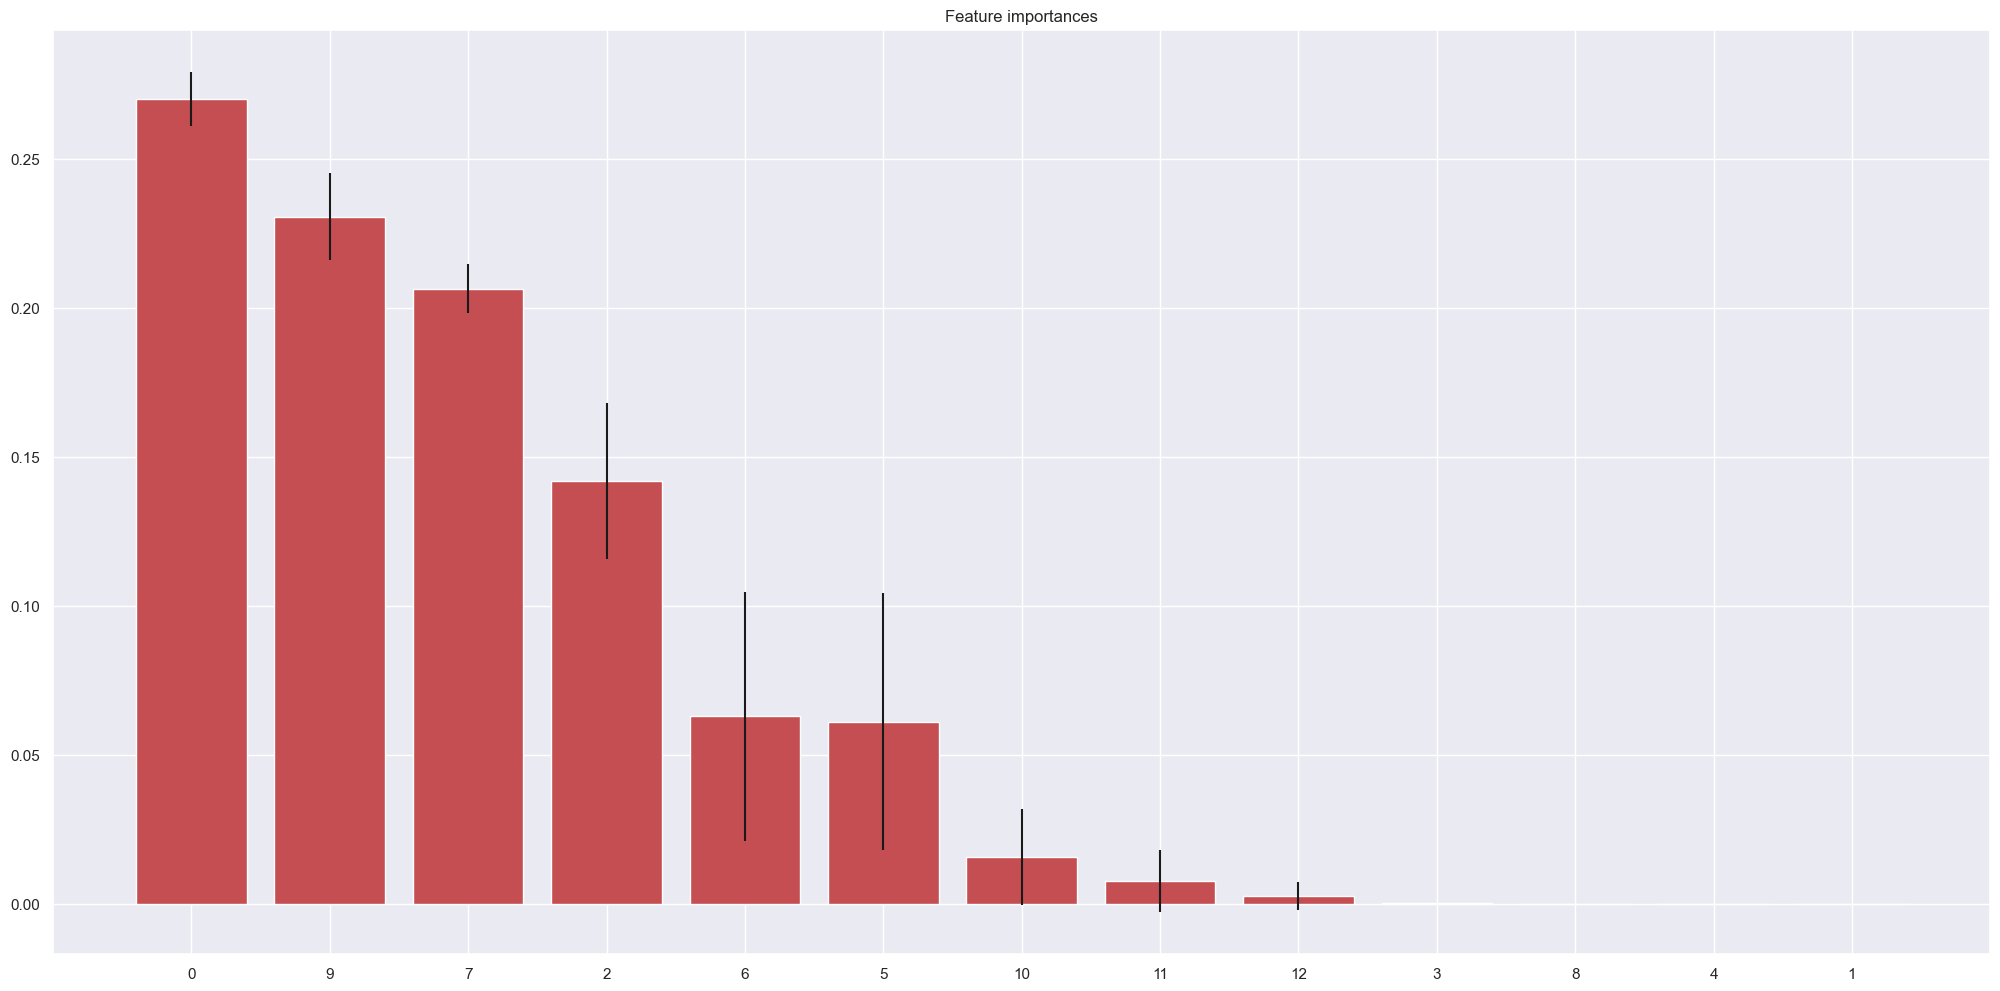

In [52]:
importances = extratrees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extratrees.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_et, extratrees.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
plt.xticks(range(x_train_n.shape[1]), indexes)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.3. Manual Feature Selection

In [53]:
cols_selected_boruta_et

['age']

In [54]:
# more features
feats_to_add = ['annual_premium', 'vintage', 'region_code', 'vehicle_damage', 'previously_insured']

# final list of features
cols_selected_boruta_full = cols_selected_boruta_et.copy()
cols_selected_boruta_full.extend(feats_to_add)

In [55]:
X_train = X_train[cols_selected_boruta_full]
X_test = X_test[cols_selected_boruta_full]
# X_val = X_val[cols_selected_boruta_full]

# 7.0. Machine Learning Modelling

In [56]:
df7 = X_test.copy()
df7['response'] = y_test.copy()

## 7.1. k-NN Classifier

In [57]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(X_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(X_test)

In [58]:
# propensity score
df7['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)

# compute precision at k 
knn_precision_at_50 = precision_at_k(df7, k = 50)
print('Precision at K: {}'.format(knn_precision_at_50))

# compute recall at k
knn_recall_at_50 = recall_at_k(df7, k = 50)
print('Recall at K: {}'.format(knn_recall_at_50))

Precision at K: 0.3333333333333333
Recall at K: 0.0017851517378977212


## 7.2. Logistic Regression

In [59]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42) 

# model training
lr_model.fit(X_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(X_test)

In [60]:
# propensity score
df7['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)

# compute precision at k 
lr_precision_at_50 = precision_at_k(df7, k = 50)
print('Precision at K: {}'.format(lr_precision_at_50))

# compute recall at k
lr_recall_at_50 = recall_at_k(df7, k = 50)
print('Recall at K: {}'.format(lr_recall_at_50))

Precision at K: 0.058823529411764705
Recall at K: 0.0003150267772760685


## 7.3. Random Forest

In [61]:
# model definition
rf = en.RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 42) 

# model training
rf.fit(X_train, y_train)

# model prediction
yhat_rf = rf.predict_proba(X_test)

In [62]:
# propensity score
df7['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)

# compute precision at k 
rf_precision_at_50 = precision_at_k(df7, k = 50)
print('Precision at K: {}'.format(rf_precision_at_50))

# compute recall at k
rf_recall_at_50 = recall_at_k(df7, k = 50)
print('Recall at K: {}'.format(rf_recall_at_50))

Precision at K: 0.17647058823529413
Recall at K: 0.0009450803318282054


## 7.4. XGBoost

In [63]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 1000, eval_metric = 'logloss', random_state = 42)

# model training
xgb_model.fit(X_train, y_train)

# model prediction
yhat_xgb_model = xgb_model.predict_proba(X_test)

In [64]:
# propensity score
df7['score'] = yhat_xgb_model[:, 1].tolist()

# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)

# compute precision at k 
xgb_precision_at_50 = precision_at_k(df7, k = 50)
print('Precision at K: {}'.format(xgb_precision_at_50))

# compute recall at k
xgb_recall_at_50 = recall_at_k(df7, k = 50)
print('Recall at K: {}'.format(xgb_recall_at_50))

Precision at K: 0.09803921568627451
Recall at K: 0.0005250446287934474


## 7.5. Performance Metrics

### 7.5.1. Cumulative Gain & Lift Curves

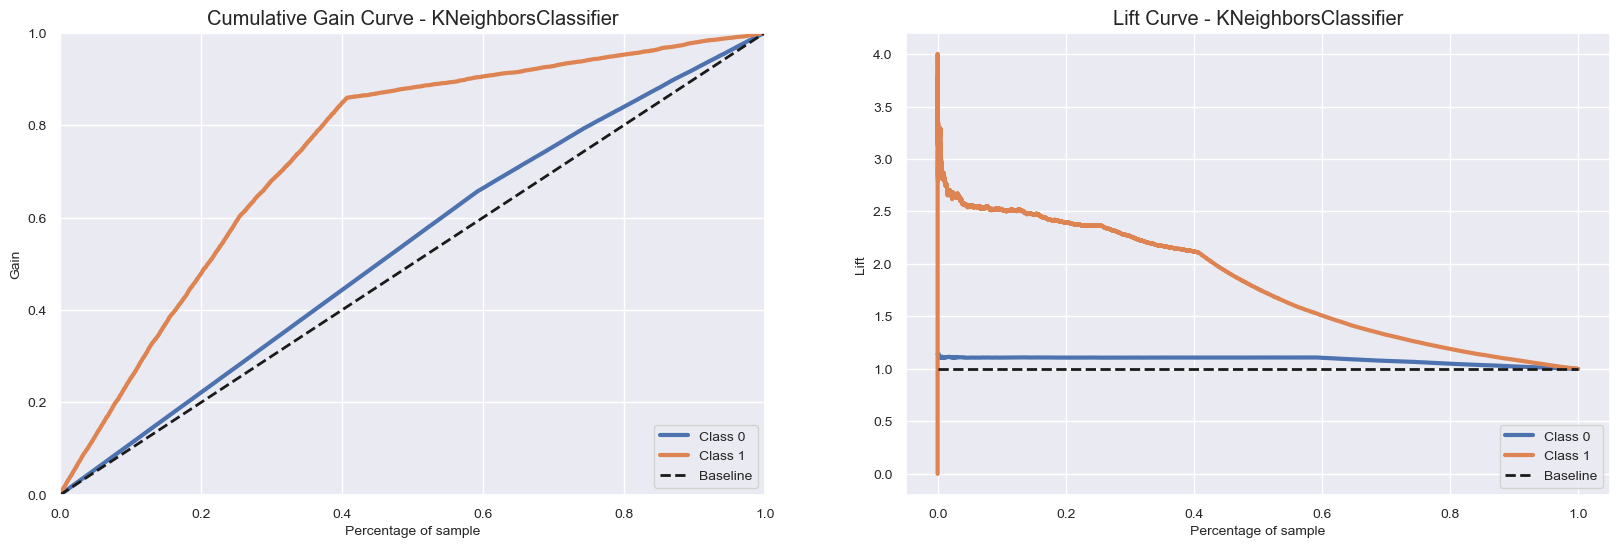

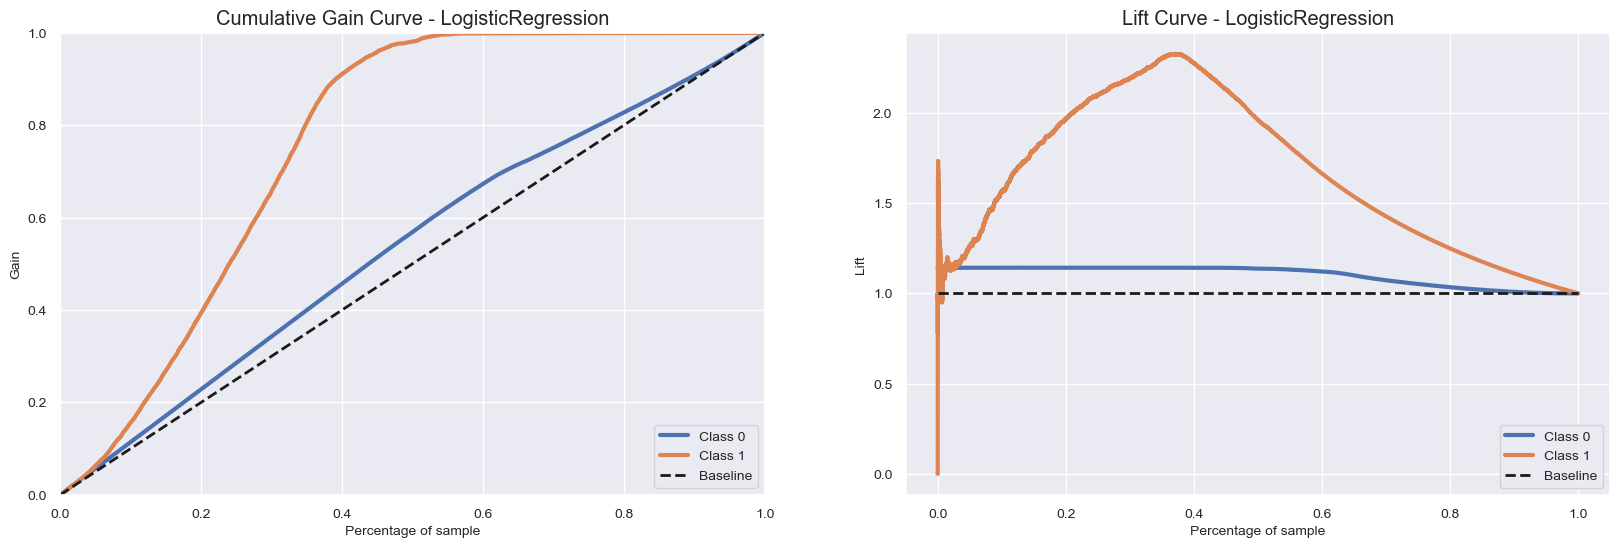

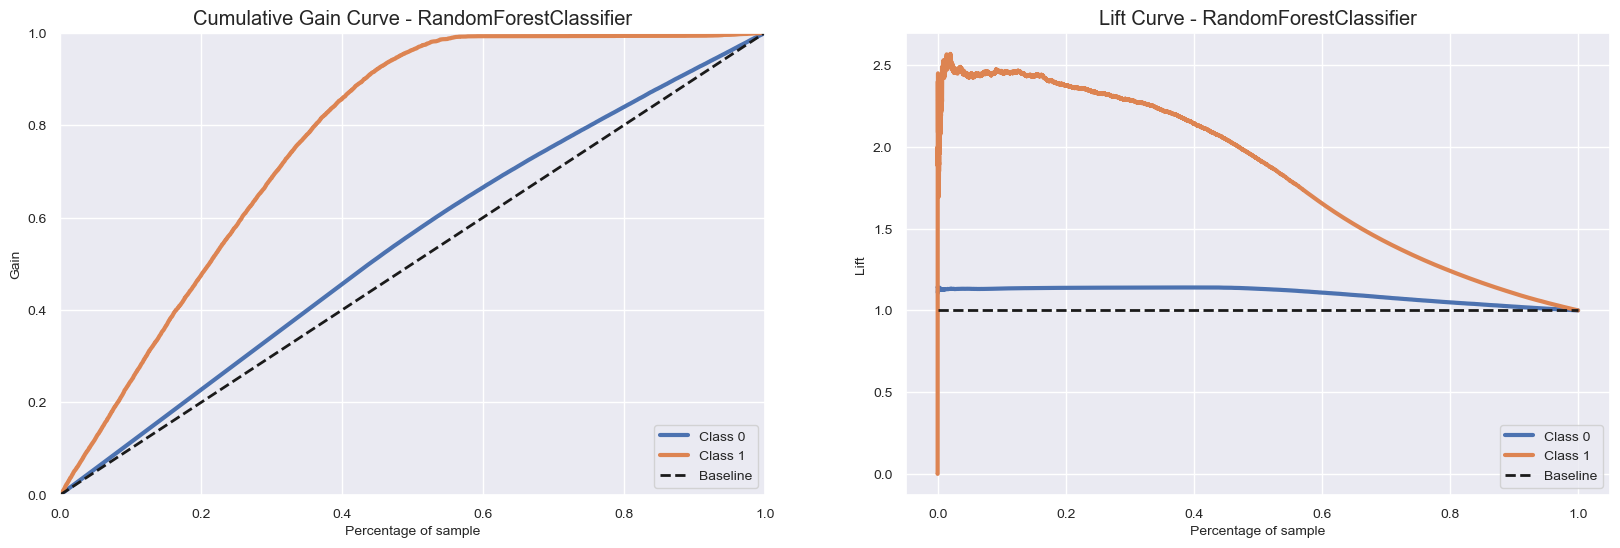

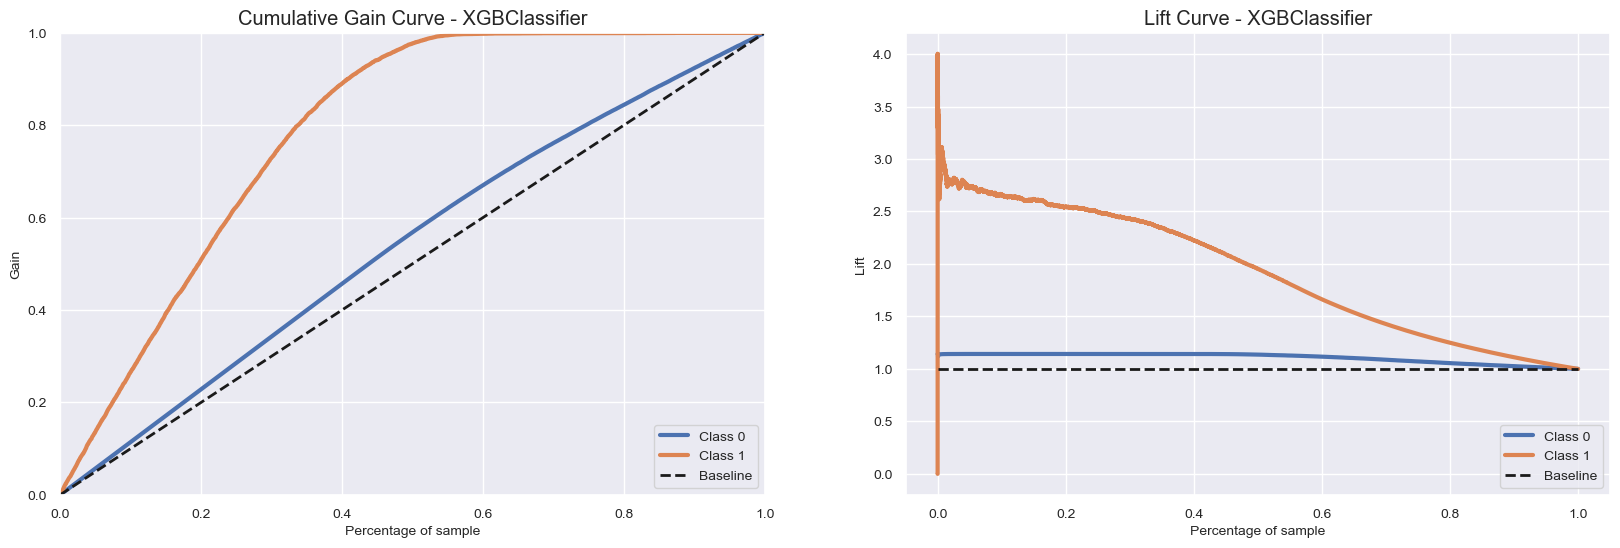

In [65]:
aux = [knn_model, lr_model, rf, xgb_model]
cgc_lc(aux, X_train, y_train, X_test)

### 7.5.2. Precision & Recall

In [66]:
knn_precision_at_50 = pd.Series(knn_precision_at_50, name='knn_precision')
knn_recall_at_50 = pd.Series(knn_recall_at_50, name='knn_recall')
lr_precision_at_50 = pd.Series(lr_precision_at_50, name='lr_precision')
lr_recall_at_50 = pd.Series(lr_recall_at_50, name='lr_recall')
rf_precision_at_50 = pd.Series(rf_precision_at_50, name='rf_precision')
rf_recall_at_50 = pd.Series(rf_recall_at_50, name='rf_recall')
xgb_precision_at_50 = pd.Series(xgb_precision_at_50, name='xgb_precision')
xgb_recall_at_50 = pd.Series(xgb_recall_at_50, name='xgb_recall')

models_precision_recall = pd.concat([knn_precision_at_50,
                                    knn_recall_at_50,
                                    lr_precision_at_50,
                                    lr_recall_at_50,
                                    rf_precision_at_50,
                                    rf_recall_at_50,
                                    xgb_precision_at_50,
                                    xgb_recall_at_50], axis=1)

models_precision_recall

,knn_precision,knn_recall,lr_precision,lr_recall,rf_precision,rf_recall,xgb_precision,xgb_recall
0,0.333333,0.001785,0.058824,0.000315,0.176471,0.000945,0.098039,0.000525


### 7.5.3. Cross-Validation

In [67]:
aux = [knn_model, lr_model, rf, xgb_model]

models_cv = cross_validation(df7, aux, X_train, y_train, 5)
models_cv

,Model_Name,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,KNeighborsClassifier,0.268200,0.001700,0.721400,0.004600
0,LogisticRegression,0.270700,0.002900,0.728000,0.007700
0,RandomForestClassifier,0.271500,0.002700,0.730100,0.007300
0,XGBClassifier,0.275200,0.006800,0.740000,0.018300


# 8.0. Hyperparameter Fine Tunning

In [68]:
# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'fit_intercept': [True, False],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [100, 1000, 10000]
#     }
# 
# # Cross-Validation
# cv = ms.KFold(n_splits = 5, shuffle = True, random_state = 42)
# f1_scorer = m.make_scorer(m.f1_score, average = 'macro')
# 
# # Perform Random Search with Cross-Validation
# random = ms.RandomizedSearchCV(lr_model, param_distributions = param_grid, 
#                             n_iter = 100, cv = cv, scoring = f1_scorer, n_jobs = -1, random_state = 42)
# random.fit(X_train, y_train)
# 
# # Best parameters and f1-Score
# print('Best parameters:', random.best_params_)
# print('Best f1-Score:', random.best_score_)
# 
# # Evaluation on the validation set
# y_val_pred = random.predict(X_val)
# f1 = m.f1_score(y_val, y_val_pred, average = 'macro')
# print("F1-score on validation set:", f1)

In [69]:
param_tuned = {'solver': 'newton-cg', 'penalty': 'none', 'max_iter': 100, 'fit_intercept': True, 'C': 1}

In [70]:
# model
lr_tuned = lm.LogisticRegression(
    solver = param_tuned['solver'],
    penalty = param_tuned['penalty'],
    max_iter = param_tuned['max_iter'],
    fit_intercept = param_tuned['fit_intercept'],
    C = param_tuned['C'], 
    random_state = 42, n_jobs = -1).fit(X_train, y_train)

# prediction
yhat_lr_tuned = lr_tuned.predict(X_test)

# performance
scores = ms.cross_val_score(lr_tuned, X_train, y_train, cv = 5, scoring = 'f1')
print("Cross-validation F1-Score: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))

Cross-validation F1-Score: 0.000215 (+/- 0.000402)


In [71]:
yhat_lr_t = lr_tuned.predict_proba(X_test)

# propensity score
df7['score'] = yhat_lr_t[:, 1].tolist()

# sort clients by propensity score
df7 = df7.sort_values('score', ascending = False)

# compute precision at k 
lr_tuned_precision_at_50 = precision_at_k(df7, k = 50)
print('Precision at K: {}'.format(lr_tuned_precision_at_50))

# compute recall at k
lr_tuned_recall_at_50 = recall_at_k(df7, k = 50)
print('Recall at K: {}'.format(lr_tuned_recall_at_50))

Precision at K: 0.1568627450980392
Recall at K: 0.0008400714060695159


In [72]:
aux = [lr_model, lr_tuned]
models_cv = cross_validation(df7, aux, X_train, y_train, 5)
models_cv

,Model_Name,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,LogisticRegression,0.273200,0.001100,0.734700,0.003000
0,LogisticRegression,0.271000,0.002400,0.728800,0.006400


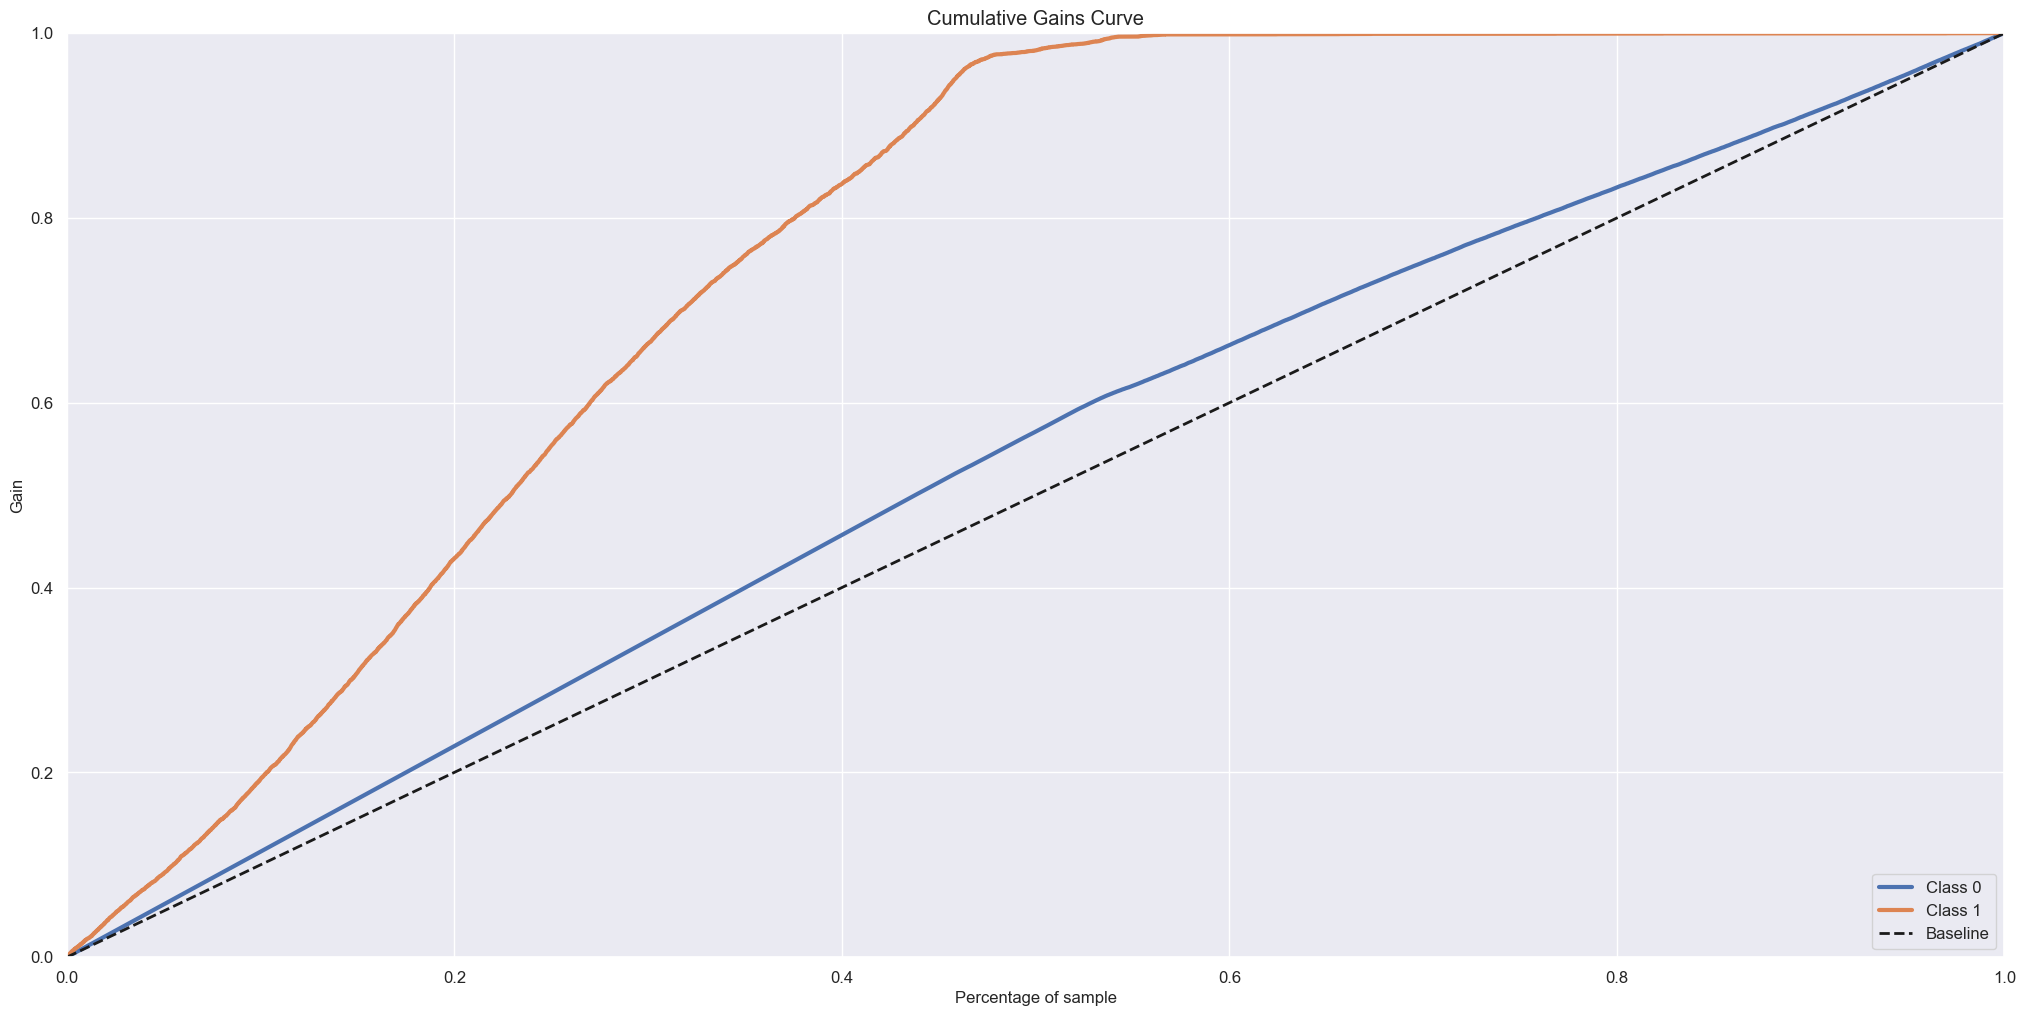

In [73]:
# Accumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_test, yhat_lr_t);

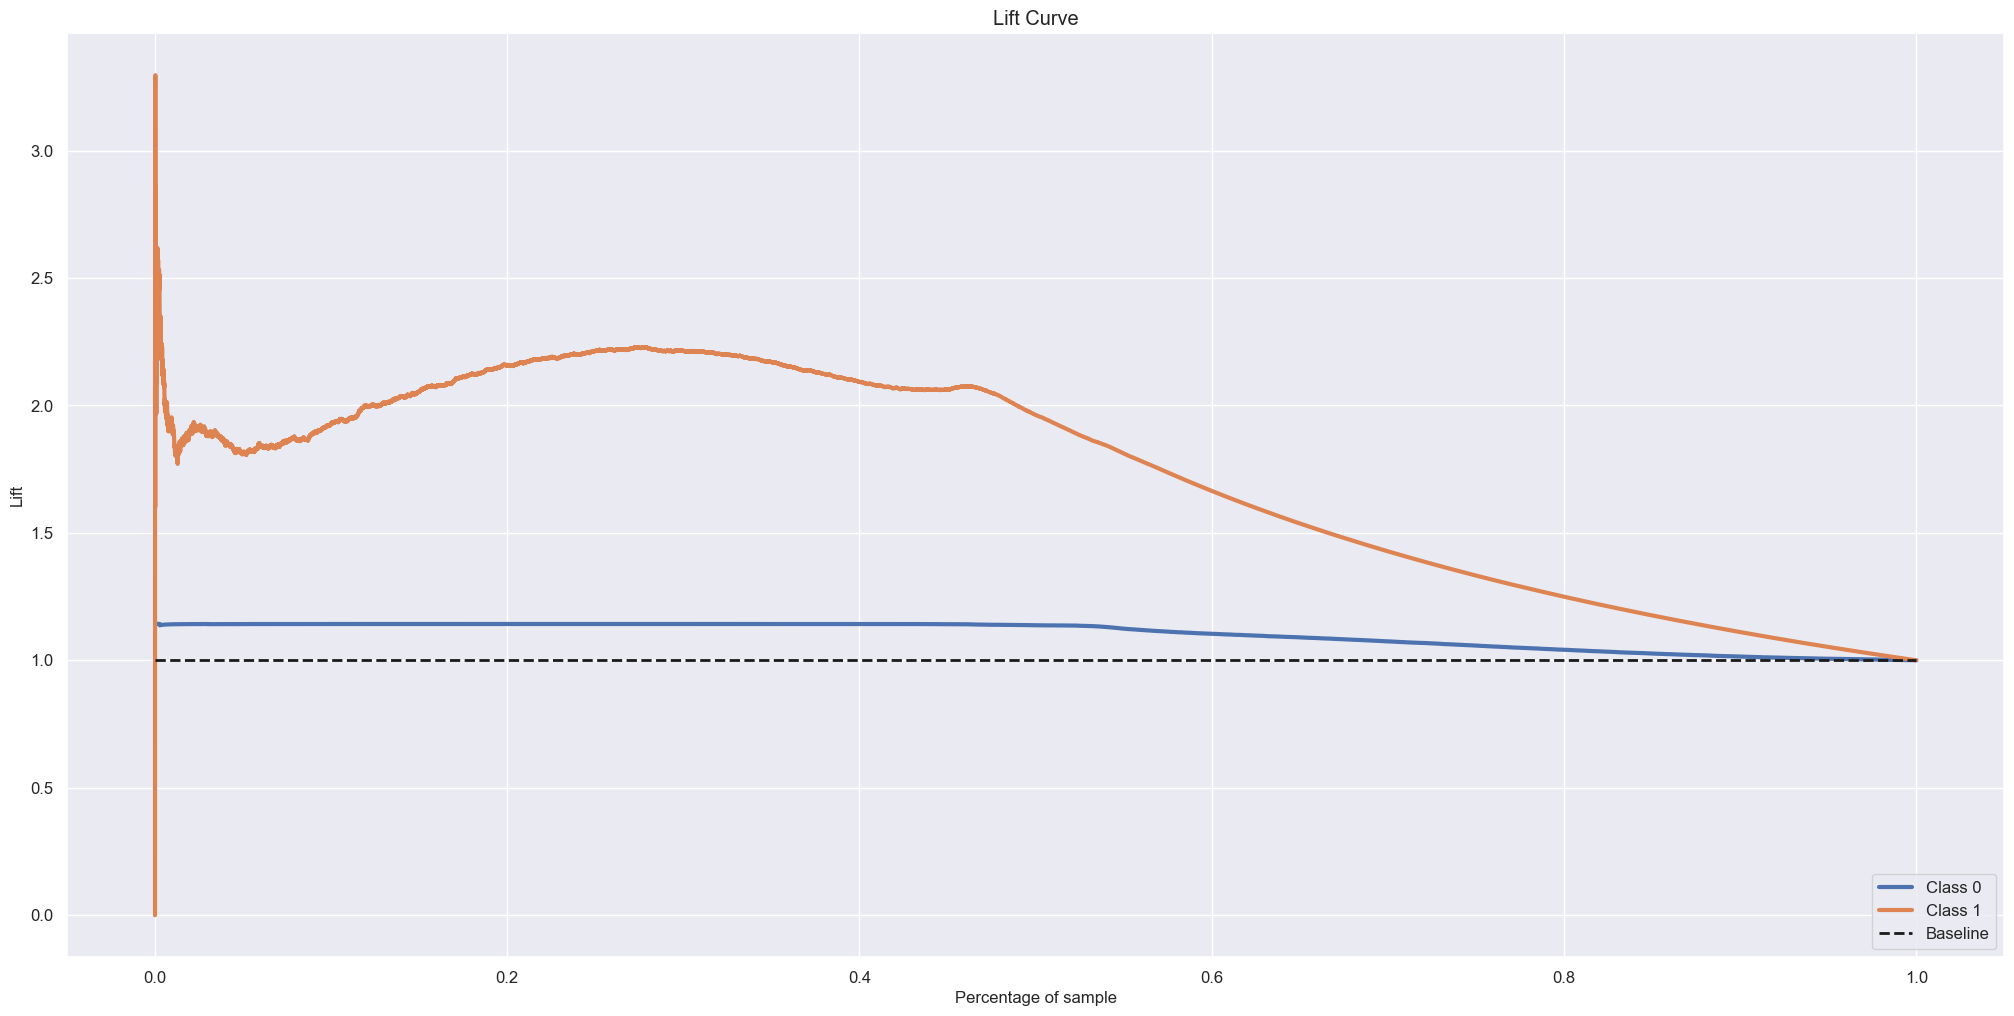

In [74]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_lr_t);

In [75]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

df8['score'] = yhat_lr_t[:, 1].tolist()

df8 = df8.sort_values('score', ascending = False)

df8.head()

,age,annual_premium,vintage,region_code,vehicle_damage,previously_insured,response,score
121687,-0.295621,-1.774234,-0.033105,0.000000,1,0,0,0.535108
208190,-0.300592,-1.774509,-0.034411,0.000000,1,0,0,0.464658
290753,-0.296568,-1.774598,-0.033644,0.000000,1,0,0,0.456921
271078,-0.299172,-1.774611,-0.032363,0.000000,1,0,0,0.447176
170380,-0.302012,-1.774678,-0.032351,0.000000,1,0,1,0.425932


# 9.0. Performance to Business Values

In [76]:
df9 = df8.copy()

In [77]:
df_final = df9.copy()
df_final.to_csv('../data/processed/df_final.csv', index = 'False')

df_sample = df_final.sample(100)
df_sample.to_csv('../data/processed/df_sample.csv', index = 'False')

1. Which variables are more relevant to an understanding of the conditions under which customers are interested in purchasing vehicle insurance?

1. vintage; 
2. annual_premium;
3. age;
4. vehicle_damage;
5. previously_insured.

2. What percentage of customers interested in purchasing vehicle insurance can the sales team reach by making 20,000 phone calls?

In [78]:
_ = round(df9['response'][:20000].sum() / df9['response'].sum() * 100)
print(f'With 20.000 calls sales team will be contact {_}% of customers interested')

With 20.000 calls sales team will be contact 58% of customers interested


3. If the sales team's limit of phone calls is increased to 40,000, what percentage of customers interested in purchasing vehicle insurance will be contacted by the sales team?


In [79]:
_ = round(df9['response'][:40000].sum() / df9['response'].sum() * 100)
print(f'With 40.000 calls sales team will be contact {_}% of customers interested')

With 40.000 calls sales team will be contact 99% of customers interested


4. How many phone calls does it take for the sales team to contact 80% of the customers interested in purchasing vehicle insurance?

In [80]:
_ = round(df9['response'][:28400].sum() / df9['response'].sum() * 100)
print(f'With 28.400 calls sales team will be contact {_}% of customers interested')

With 28.400 calls sales team will be contact 80% of customers interested


# 10.0. Deploy to Production

In [81]:
pickle.dump(lr_model, open('../src/models/model_linear_regression.pkl', 'wb'))

## 10.1. Health Insurance Class

In [82]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__(self):
        self.home_path = '/Users/pgdem/repos/health_insurance-cs/'
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'src/features/'))
        self.age_scaler = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl'))
        self.vintage_scaler = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl'))
        self.target_encode_gender_scaler = pickle.load(open(self.home_path + 'src/features/target_encode_gender_scaler.pkl'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src/features/target_encode_region_code_scaler.pkl'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl'))

    def data_cleaning(self, df1):
        # Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
        # Rename 
        df1.columns = cols_new
        
        return df1 

    def feature_engineering(self, df2):
        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        
        return df2

    def data_preparation(self, df5):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)
        # age - MinMaxScaler
        df5['age'] = self.age_scaler.transform(df5[['age']].values)
        # vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)
        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender)
        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code)
        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel)
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                        'policy_sales_channel']
        
        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
model = pickle.load(open('../src/models/model_linear_regression.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods = ['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: #multiples examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status= 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run(host='0.0.0.0', debug = True)

## 10.3. API Tester

In [85]:
import requests

In [86]:
# loading test dataset
df_test = X_test
df_test['response'] = y_test

In [87]:
df_test = df_test.sample(10)

In [88]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [102]:
# API Call

# url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-cs.onrender.com'
header = { 'Content-type': 'application/json'}

r = requests.post(url, data = data, headers = header)
print('status code {}'.format(r.status_code))

KeyboardInterrupt: 

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending = False).head()